## Step 0: To start ..

In [1]:
# Turn on multi-threading on your computer for faster calculation
%env OMP_NUM_THREADS = 4

env: OMP_NUM_THREADS=4


# Steps 1 and 2: Install and load the necessary packages and libraries

In [2]:
# Step 1: Check conda environment and installed packages and libaries
# import sys
# !conda env list
# !conda list
# !conda update --all

# Download and install pandas, numpy, scikit-learn. Note, this might need to be done in Anaconda prompt
# !conda install pandas # pandas includes numpy
# !conda install scikit-learn

# Step 2: Load the necessary packages and libaries

import numpy as np
import pandas as pd
import os.path as osp
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

# Step 3: Load the data

In [3]:
# Step 3: Loading the Credit card default data from the CSV file into the dataframe that we called df.

import os
os.chdir('C:/Users/anton/MMA 867')

path = osp.join(osp.curdir,'Data','6722-credit-card-default-data.csv')
df = pd.read_csv(path)

df.head() # show the "head" -- first 5 rows of the data; note, these are rows 0...4

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
2,3,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
3,4,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
4,5,50000.0,1,1,2,37,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0


# Step 4: "Cleaning" the data

### Data sanity check:

- No missing values, all variables have 2400 values
- Outliers exist for LIMIT_BAL, "BILL_AMT1" to "BILL_AMT6" and "PAY_AMT1" to "PAY_AMT6"
- When analyzing the 99th percentile, for BILL Amount variables the range is around 300-350K and for payment variables it is around 65-75K
- While the 1% value is around -100 to -100 for bill amount variables
- Payment variables have a minimum value of 0 so no issues there
- Since pilot customers have BIll amount and Pay amount values in the outlier range which would be used for prediction we would not be capping outlier values, instead log transformation variables will be tested along with other features

In [4]:
# "Cleaning" the data -- part 1: converting incorrect data types

df.info() # Checking what kinds of data we have

# Checking distributions for specific variables

columns_to_check = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for column in columns_to_check:
    unique_values = df[column].unique()
    print(f'Unique values in column {column}: {unique_values}')
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         24000 non-null  int64  
 1   LIMIT_BAL  24000 non-null  float64
 2   SEX        24000 non-null  int64  
 3   EDUCATION  24000 non-null  int64  
 4   MARRIAGE   24000 non-null  int64  
 5   AGE        24000 non-null  int64  
 6   PAY_1      24000 non-null  int64  
 7   PAY_2      24000 non-null  int64  
 8   PAY_3      24000 non-null  int64  
 9   PAY_4      24000 non-null  int64  
 10  PAY_5      24000 non-null  int64  
 11  PAY_6      24000 non-null  int64  
 12  BILL_AMT1  24000 non-null  float64
 13  BILL_AMT2  24000 non-null  float64
 14  BILL_AMT3  24000 non-null  float64
 15  BILL_AMT4  24000 non-null  float64
 16  BILL_AMT5  24000 non-null  float64
 17  BILL_AMT6  24000 non-null  float64
 18  PAY_AMT1   24000 non-null  float64
 19  PAY_AMT2   24000 non-null  float64
 20  PAY_AM

In [5]:
df.describe()

# Calculate the 90th and 95th percentiles
percentiles = [90, 95, 99]
percentile_values = df.quantile(q=[p / 100 for p in percentiles])

# Concatenate the percentiles DataFrame with the original describe output
result = pd.concat([df.describe(), percentile_values.rename({p / 100: f'{p}% percentile' for p in percentiles})])

print(result)

                          ID       LIMIT_BAL           SEX     EDUCATION  \
count           24000.000000    24000.000000  24000.000000  24000.000000   
mean            12000.500000   167876.403333      1.600917      1.850958   
std              6928.347566   129907.454723      0.489720      0.787361   
min                 1.000000    10000.000000      1.000000      0.000000   
25%              6000.750000    50000.000000      1.000000      1.000000   
50%             12000.500000   140000.000000      2.000000      2.000000   
75%             18000.250000   240000.000000      2.000000      2.000000   
max             24000.000000  1000000.000000      2.000000      6.000000   
90% percentile  21600.100000   360000.000000      2.000000      3.000000   
95% percentile  22800.050000   430000.000000      2.000000      3.000000   
99% percentile  23760.010000   500000.000000      2.000000      5.000000   

                    MARRIAGE           AGE         PAY_1         PAY_2  \
count        

# Visualizations and EDA

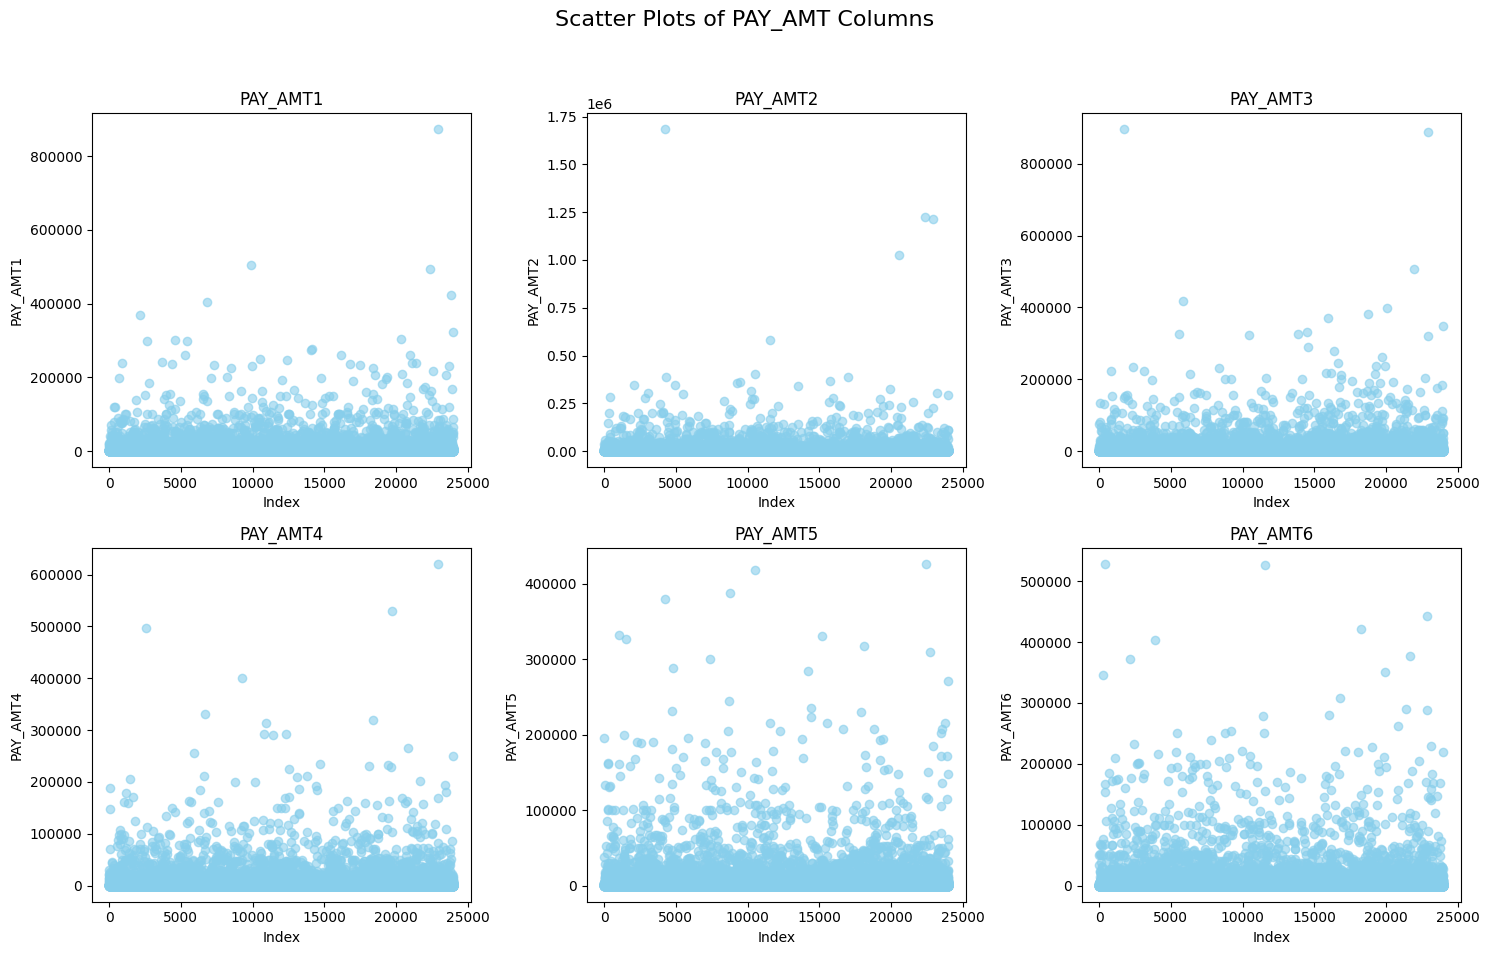

In [6]:
# Columns to create scatter plots for
pay_amt_columns = ['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Create subplots for scatter plots of PAY_AMT columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Scatter Plots of PAY_AMT Columns', fontsize=16)

# Loop through the PAY_AMT columns and create scatter plots
for i, pay_amt_col in enumerate(pay_amt_columns):
    row, col = divmod(i, 3)
    axes[row, col].scatter(df.index, df[pay_amt_col], color='skyblue', alpha=0.6)
    axes[row, col].set_title(pay_amt_col)
    axes[row, col].set_xlabel('Index')
    axes[row, col].set_ylabel(pay_amt_col)

# Adjust subplot spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

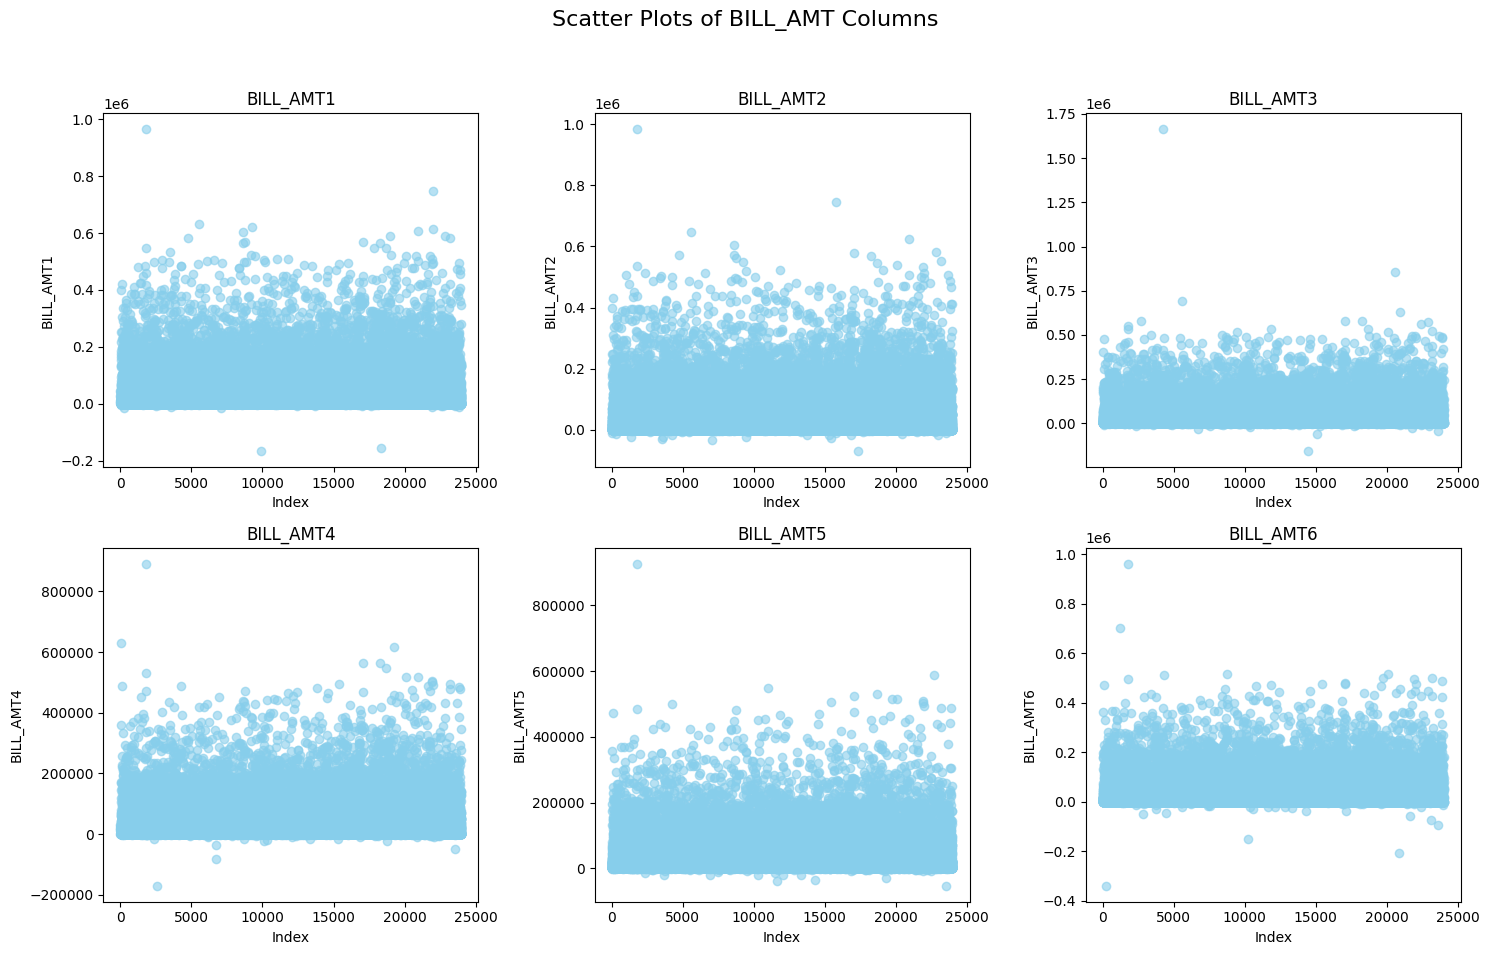

In [7]:
# Columns to create scatter plots for
bill_amt_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

# Create subplots for scatter plots of BILL_AMT columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Scatter Plots of BILL_AMT Columns', fontsize=16)

# Loop through the BILL_AMT columns and create scatter plots
for i, bill_amt_col in enumerate(bill_amt_columns):
    row, col = divmod(i, 3)
    axes[row, col].scatter(df.index, df[bill_amt_col], color='skyblue', alpha=0.6)
    axes[row, col].set_title(bill_amt_col)
    axes[row, col].set_xlabel('Index')
    axes[row, col].set_ylabel(bill_amt_col)

# Adjust subplot spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

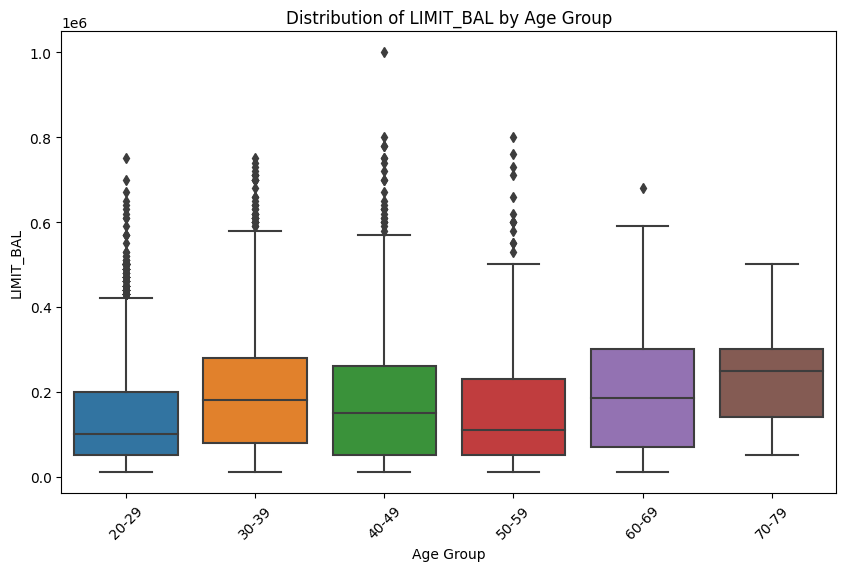

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define the age bin edges and labels
age_bins = [20, 30, 40, 50, 60, 70, 80]
age_labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']

# Create a new column 'AGE_GROUP' based on the age bins
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=age_bins, labels=age_labels)

# Create a box plot to visualize the distribution of LIMIT_BAL by age group
plt.figure(figsize=(10, 6))
sns.boxplot(x='AGE_GROUP', y='LIMIT_BAL', data=df, order=age_labels)
plt.title('Distribution of LIMIT_BAL by Age Group')
plt.xlabel('Age Group')
plt.ylabel('LIMIT_BAL')
plt.xticks(rotation=45)
plt.show()

## Feature Engineering Ideas: 

- 50 bins to be made for LIMIT BAL variable - Customers with lower limit balances have higher default rates ~35%
- 30 bins for age, 71 - 72 year olds have about 55% default rates
- Males have a slightly higher default rate than females
- Repayment statuses of -2 (no need to pay), -1 (paid in full) 0 (revolving credit) typically have lower default rates, while those with payment delays of 1 month or more hav higher default rates - can test with 3 buckets here: 1, 2-4 and >4
- In addition can add variables at a customer level for number of times in the preceeding months has a customer fallen in each repayment status bucket
- Create 10 buckets each for PAY_AMT1 - 6 and BILL_AMT1 - 6

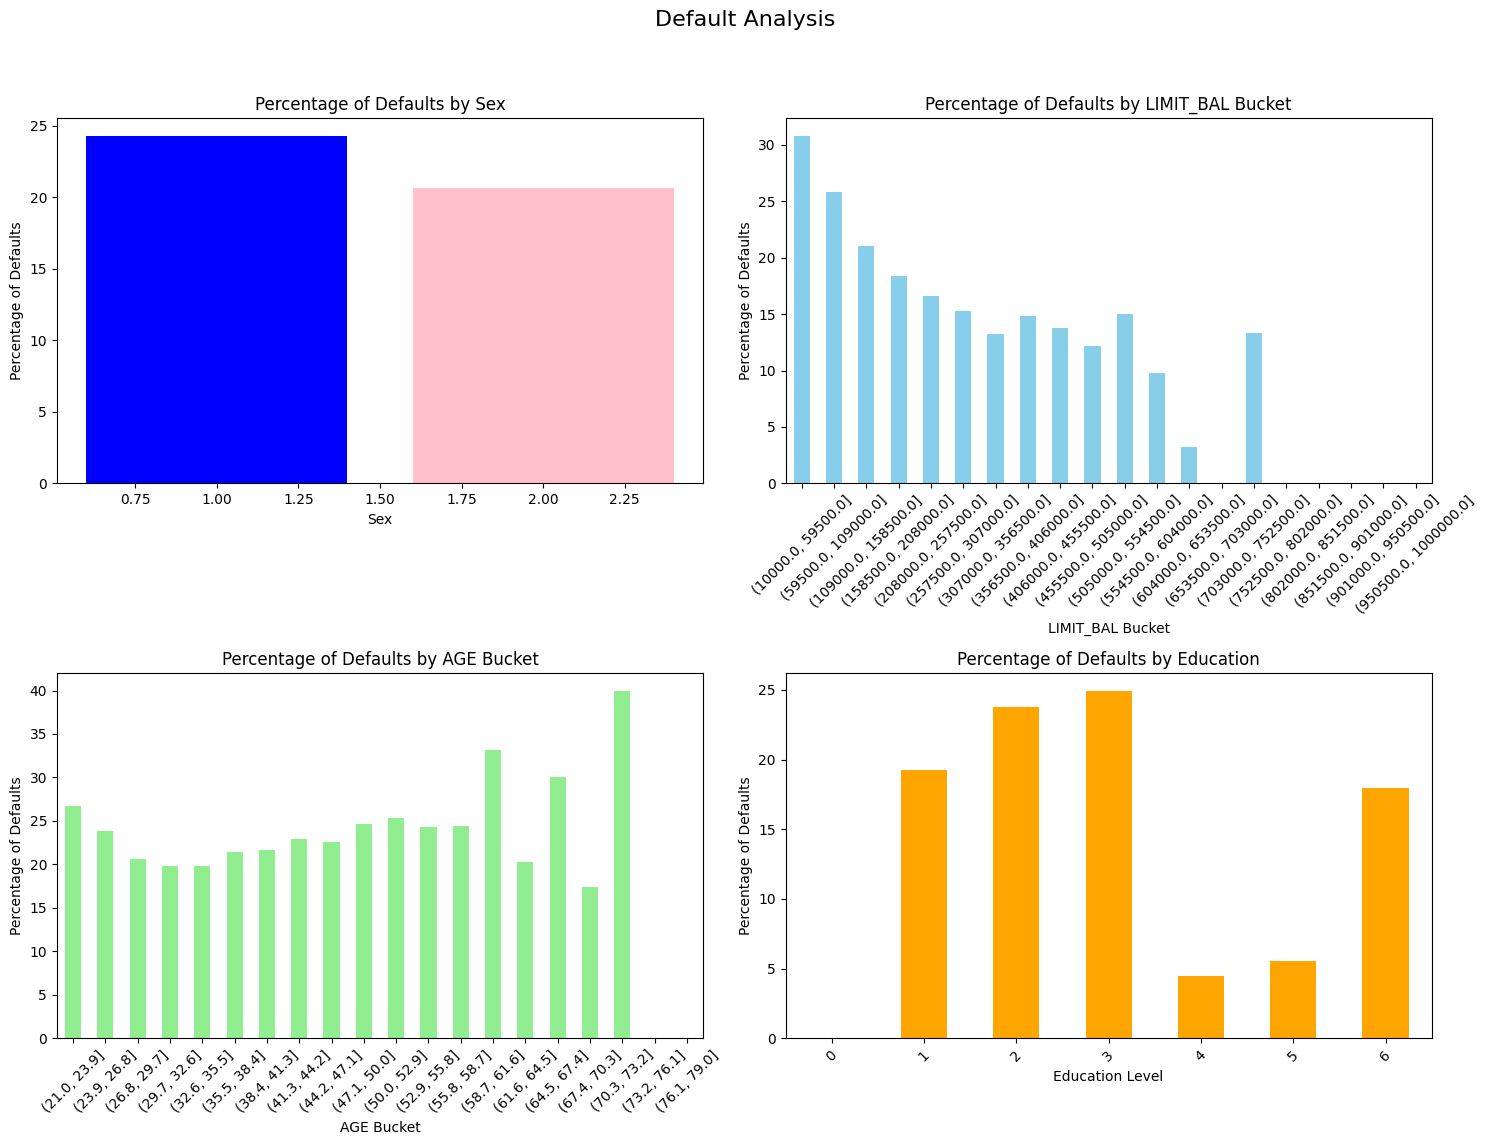

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define the range for the bins based on the min and max values of LIMIT_BAL and AGE
min_limit_balance = df['LIMIT_BAL'].min()
max_limit_balance = df['LIMIT_BAL'].max()
min_age = df['AGE'].min()
max_age = df['AGE'].max()

# Create 10 equal limit balance bins
limit_balance_bins = np.linspace(min_limit_balance, max_limit_balance, num=21)
age_bins = np.linspace(min_age, max_age, num=21)

# Use the cut function to categorize data into the bins for LIMIT_BAL and AGE
df['LIMIT_BAL_Bucket'] = pd.cut(df['LIMIT_BAL'], limit_balance_bins)
df['AGE_Bucket'] = pd.cut(df['AGE'], age_bins)

# Calculate the percentage of defaults for each gender
default_percentages_sex = df.groupby('SEX')['DEFAULT'].mean() * 100

# Calculate the percentage of defaults within each LIMIT_BAL bucket
default_percentages_limit_balance = df.groupby('LIMIT_BAL_Bucket')['DEFAULT'].mean() * 100

# Calculate the percentage of defaults within each AGE bucket
default_percentages_age = df.groupby('AGE_Bucket')['DEFAULT'].mean() * 100

# Calculate the percentage of defaults by education level
default_percentages_education = df.groupby('EDUCATION')['DEFAULT'].mean() * 100

# Create subplots with multiple plots side by side
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Default Analysis', fontsize=16)

# Plot 1: Percentage of Defaults by Sex
axes[0, 0].bar(default_percentages_sex.index, default_percentages_sex, color=['blue', 'pink'])
axes[0, 0].set_title('Percentage of Defaults by Sex')
axes[0, 0].set_xlabel('Sex')
axes[0, 0].set_ylabel('Percentage of Defaults')

# Plot 2: Percentage of Defaults by LIMIT_BAL Bucket
default_percentages_limit_balance.plot(kind='bar', ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Percentage of Defaults by LIMIT_BAL Bucket')
axes[0, 1].set_xlabel('LIMIT_BAL Bucket')
axes[0, 1].set_ylabel('Percentage of Defaults')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Percentage of Defaults by AGE Bucket
default_percentages_age.plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Percentage of Defaults by AGE Bucket')
axes[1, 0].set_xlabel('AGE Bucket')
axes[1, 0].set_ylabel('Percentage of Defaults')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Percentage of Defaults by EDUCATION
default_percentages_education.plot(kind='bar', ax=axes[1, 1], color='orange')
axes[1, 1].set_title('Percentage of Defaults by Education')
axes[1, 1].set_xlabel('Education Level')
axes[1, 1].set_ylabel('Percentage of Defaults')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust subplot spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [70]:
pip install --upgrade pandas

Note: you may need to restart the kernel to use updated packages.


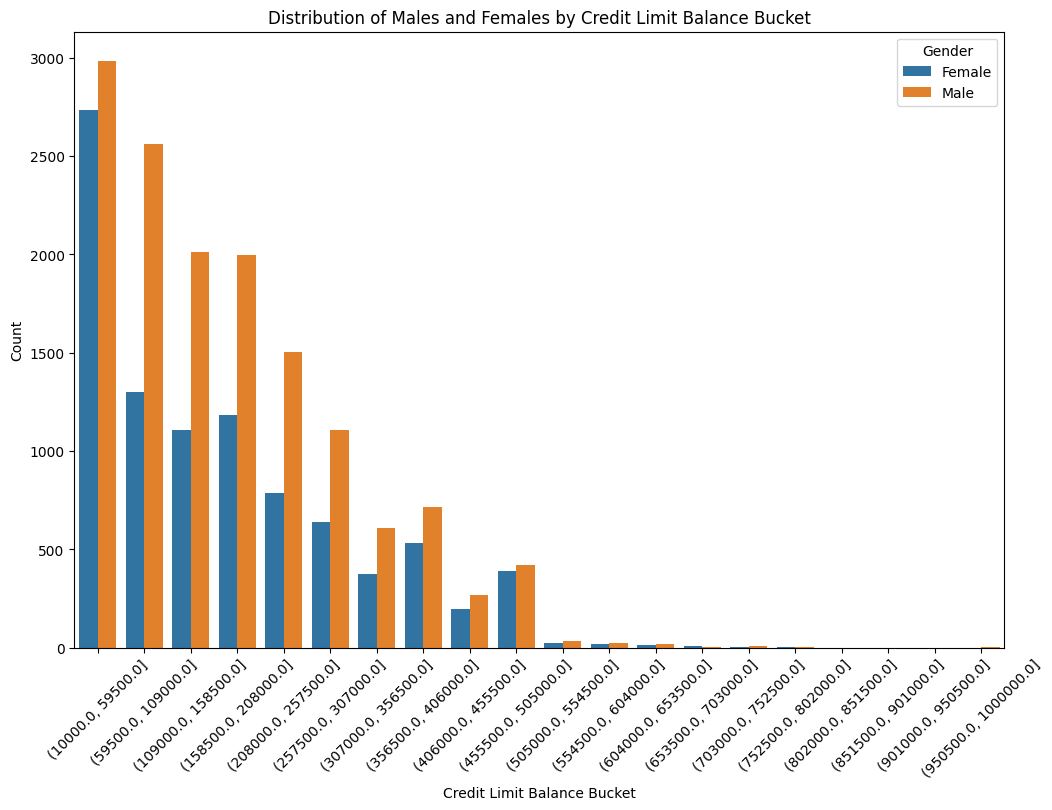

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create 10 equal limit balance bins
limit_balance_bins = np.linspace(min_limit_balance, max_limit_balance, num=21)

# Use the cut function to categorize data into the bins for LIMIT_BAL and AGE
df['LIMIT_BAL_Bucket'] = pd.cut(df['LIMIT_BAL'], limit_balance_bins)

# Create a DataFrame with the necessary data
data = df.groupby(['LIMIT_BAL_Bucket', 'SEX', 'DEFAULT']).size().unstack(fill_value=0)
data = data.reset_index()
data['Total'] = data[0] + data[1]

# Create a stacked bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='LIMIT_BAL_Bucket', y='Total', hue='SEX', data=data, ci=None)
plt.title('Distribution of Males and Females by Credit Limit Balance Bucket')
plt.xlabel('Credit Limit Balance Bucket')
plt.ylabel('Count')
plt.legend(title='Gender', labels=['Female', 'Male'])
plt.xticks(rotation=45)
plt.show()

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (3).

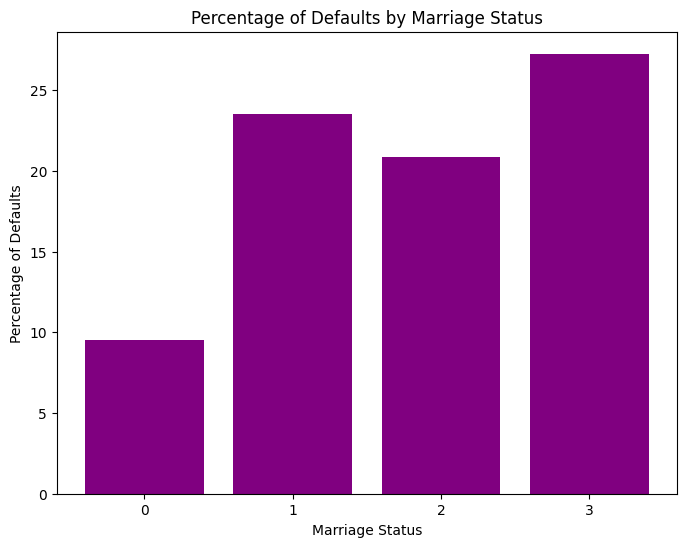

In [12]:
# Calculate the percentage of defaults by marriage status
default_percentages_marriage = df.groupby('MARRIAGE')['DEFAULT'].mean() * 100

# Create a bar plot for Percentage of Defaults by Marriage
plt.figure(figsize=(8, 6))
plt.bar(default_percentages_marriage.index, default_percentages_marriage, color='purple')
plt.title('Percentage of Defaults by Marriage Status')
plt.xlabel('Marriage Status')
plt.ylabel('Percentage of Defaults')
plt.xticks(default_percentages_marriage.index, ['Married', 'Single', 'Others'])
plt.show()

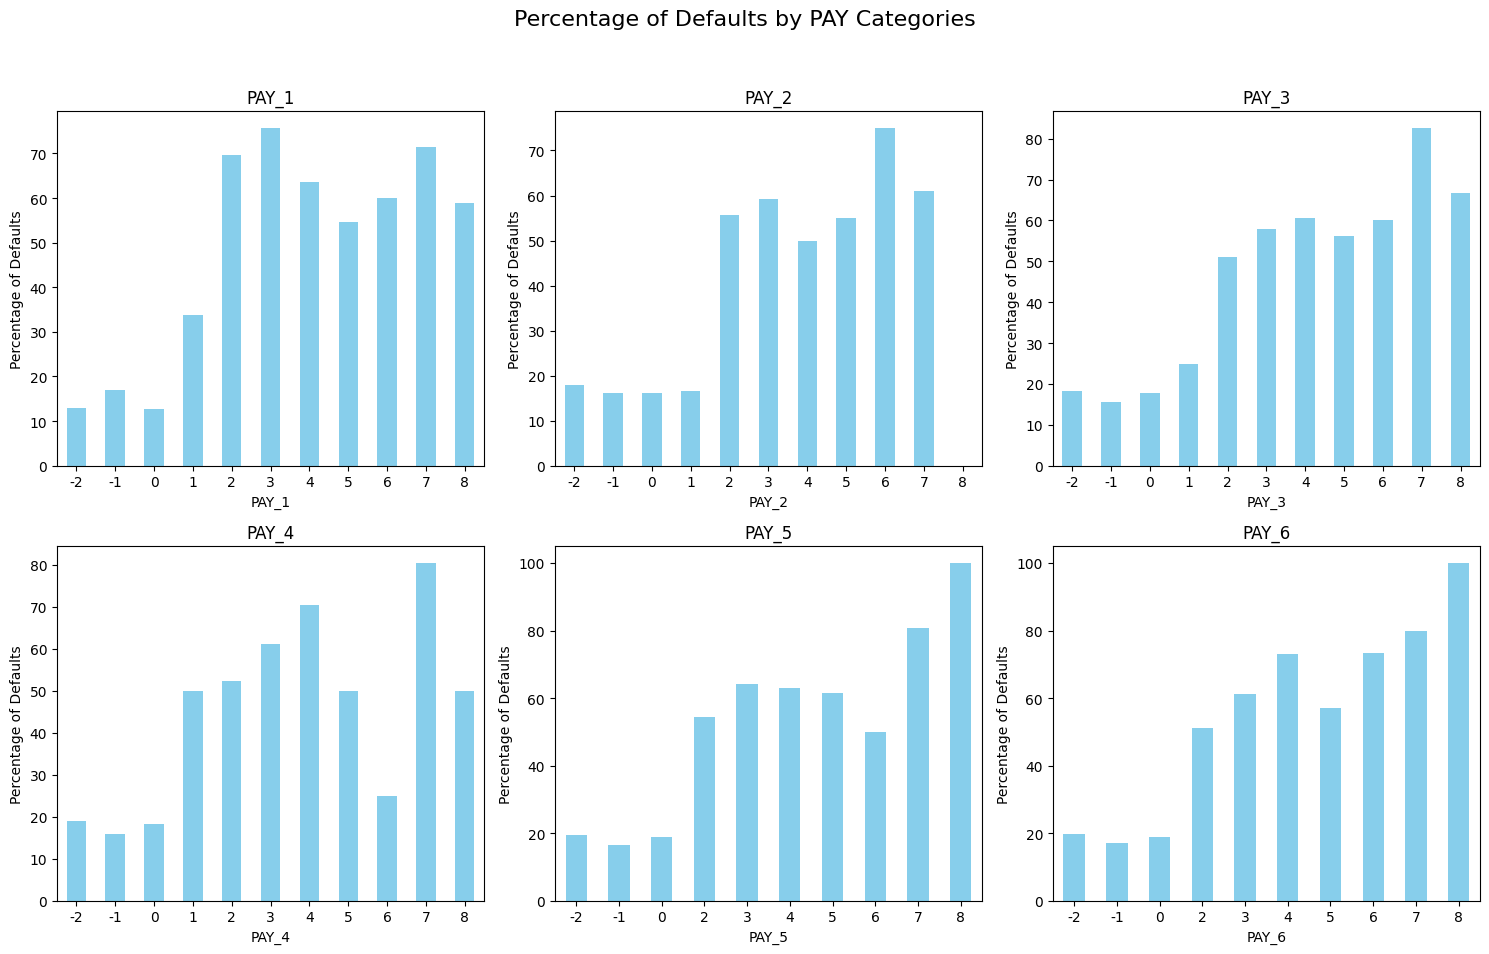

In [13]:
# Create a list of PAY columns to loop through
pay_columns = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Create subplots with multiple plots side by side
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Percentage of Defaults by PAY Categories', fontsize=16)

# Loop through PAY columns and create individual bar plots
for i, pay_col in enumerate(pay_columns):
    row, col = divmod(i, 3)
    
    # Calculate the percentage of defaults for each PAY category without creating labels
    default_percentages = df.groupby(pay_col)['DEFAULT'].mean() * 100
    
    # Create the bar plot for the current PAY column
    ax = axes[row, col]
    default_percentages.plot(kind='bar', color='skyblue', ax=ax)
    ax.set_title(f'{pay_col}')
    ax.set_xlabel(f'{pay_col}')
    ax.set_ylabel('Percentage of Defaults')
    ax.tick_params(axis='x', rotation=0)

# Adjust subplot spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

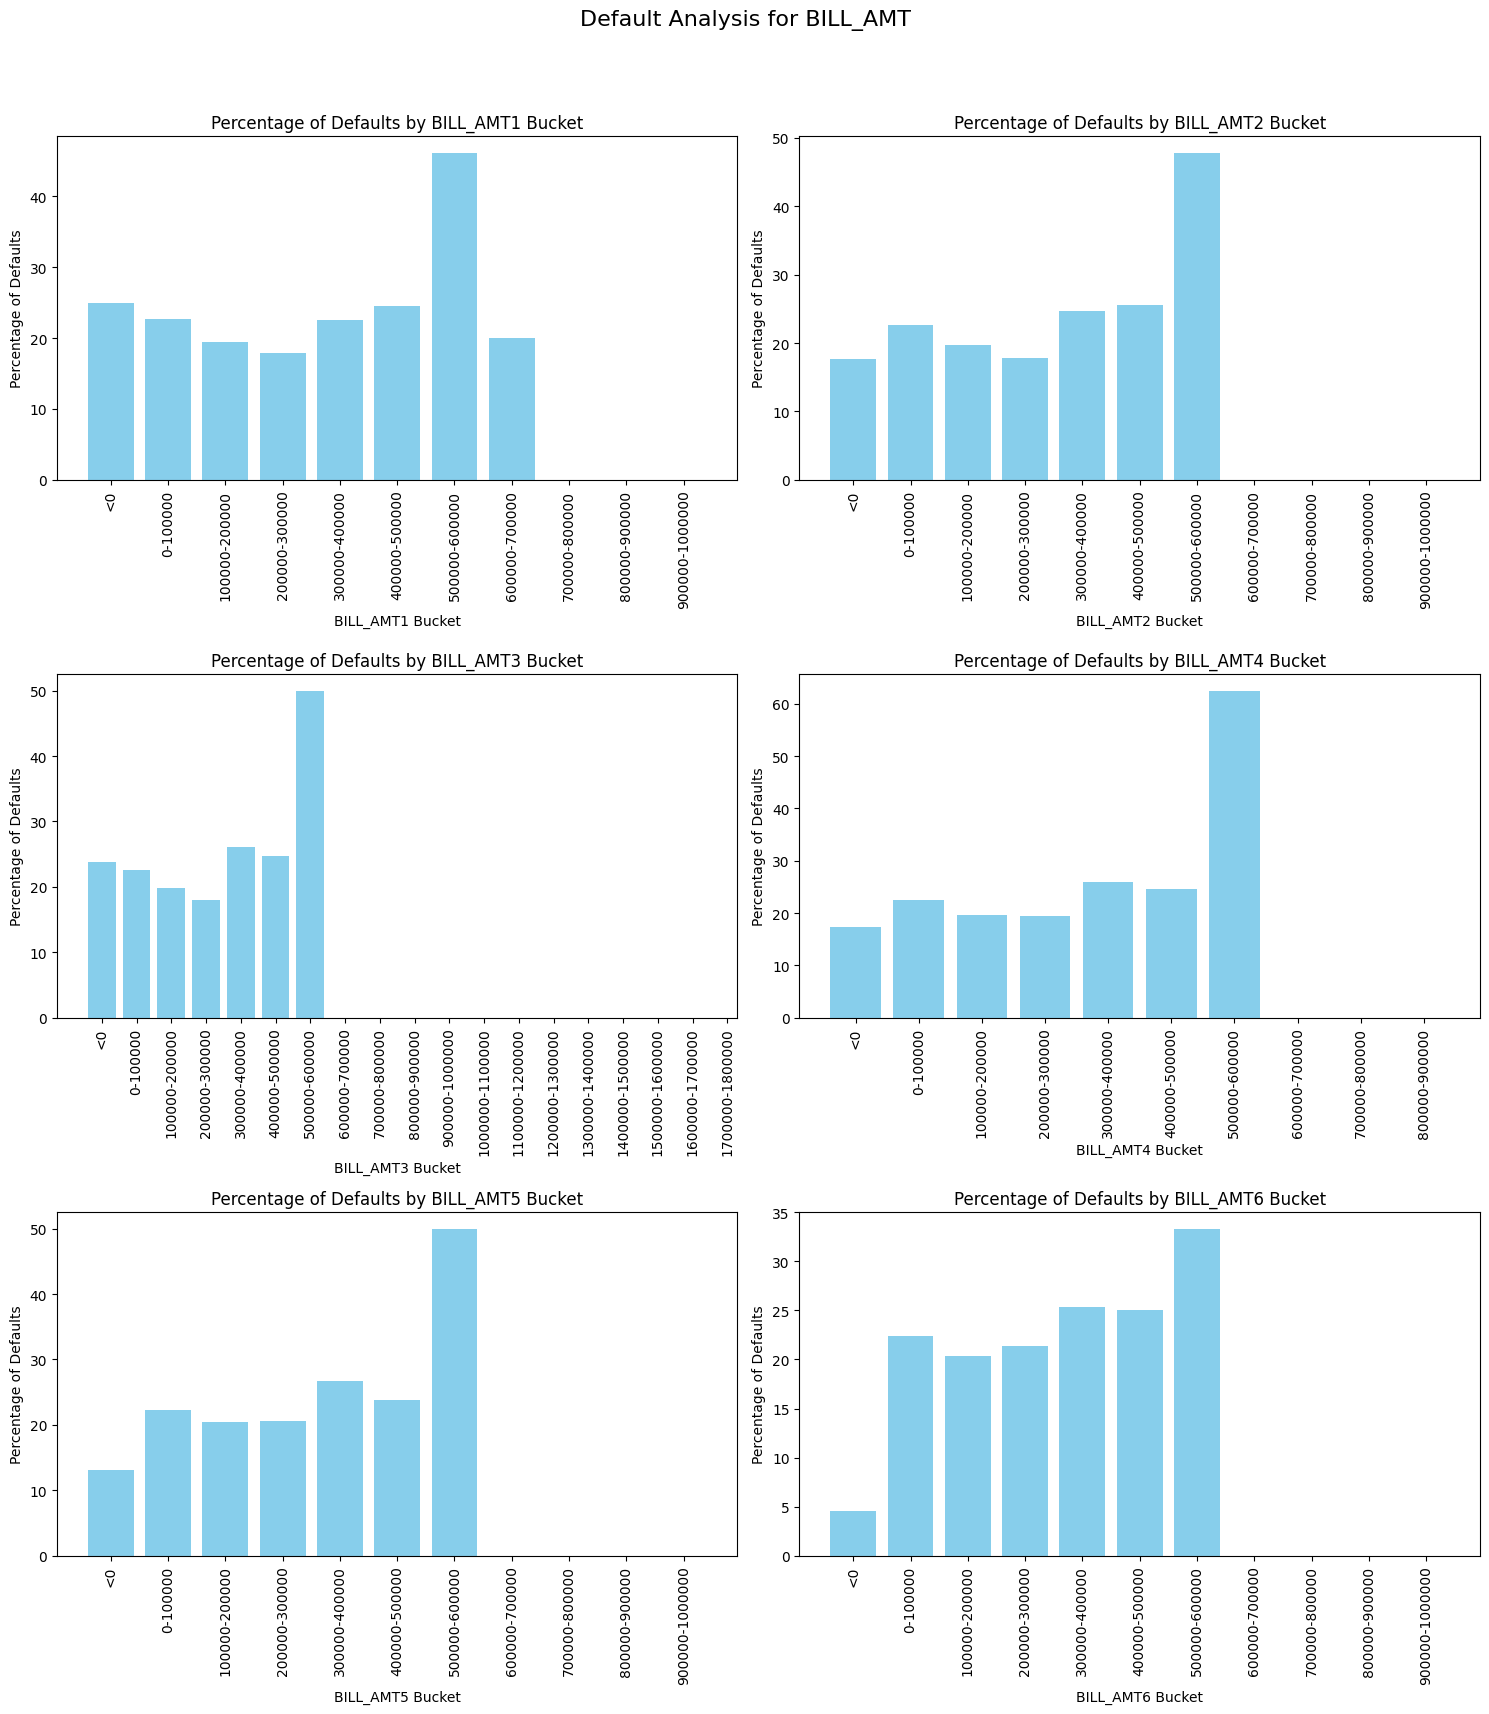

In [14]:
# Create subplots with multiple plots side by side
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('Default Analysis for BILL_AMT', fontsize=16)

# Loop through BILL_AMT columns and create individual bar plots
for i, (amt_col, title) in enumerate(zip(['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'],
                                         ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'])):
    # Define the custom bins with a step size of 100,000 up to 2,000,000
    custom_bins = [-1] + list(range(0, 2000001, 100000))
    
    # Use the cut function to categorize data into the custom bins for the current BILL_AMT column
    df[f'{amt_col}_Bucket'] = pd.cut(df[amt_col], custom_bins, labels=["<0"] + [f"{i}-{i+100000}" for i in range(0, 2000000, 100000)], right=False)
    
    # Calculate the percentage of defaults within each BILL_AMT bucket
    default_percentages = df.groupby(f'{amt_col}_Bucket')['DEFAULT'].mean() * 100
    
    # Create the bar plot for the current BILL_AMT column
    row, col = divmod(i, 2)
    axes[row, col].bar(default_percentages.index.astype(str), default_percentages, color='skyblue')
    axes[row, col].set_title(f'Percentage of Defaults by {title} Bucket')
    axes[row, col].set_xlabel(f'{title} Bucket')
    axes[row, col].set_ylabel('Percentage of Defaults')
    axes[row, col].tick_params(axis='x', rotation=90)

# Adjust subplot spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

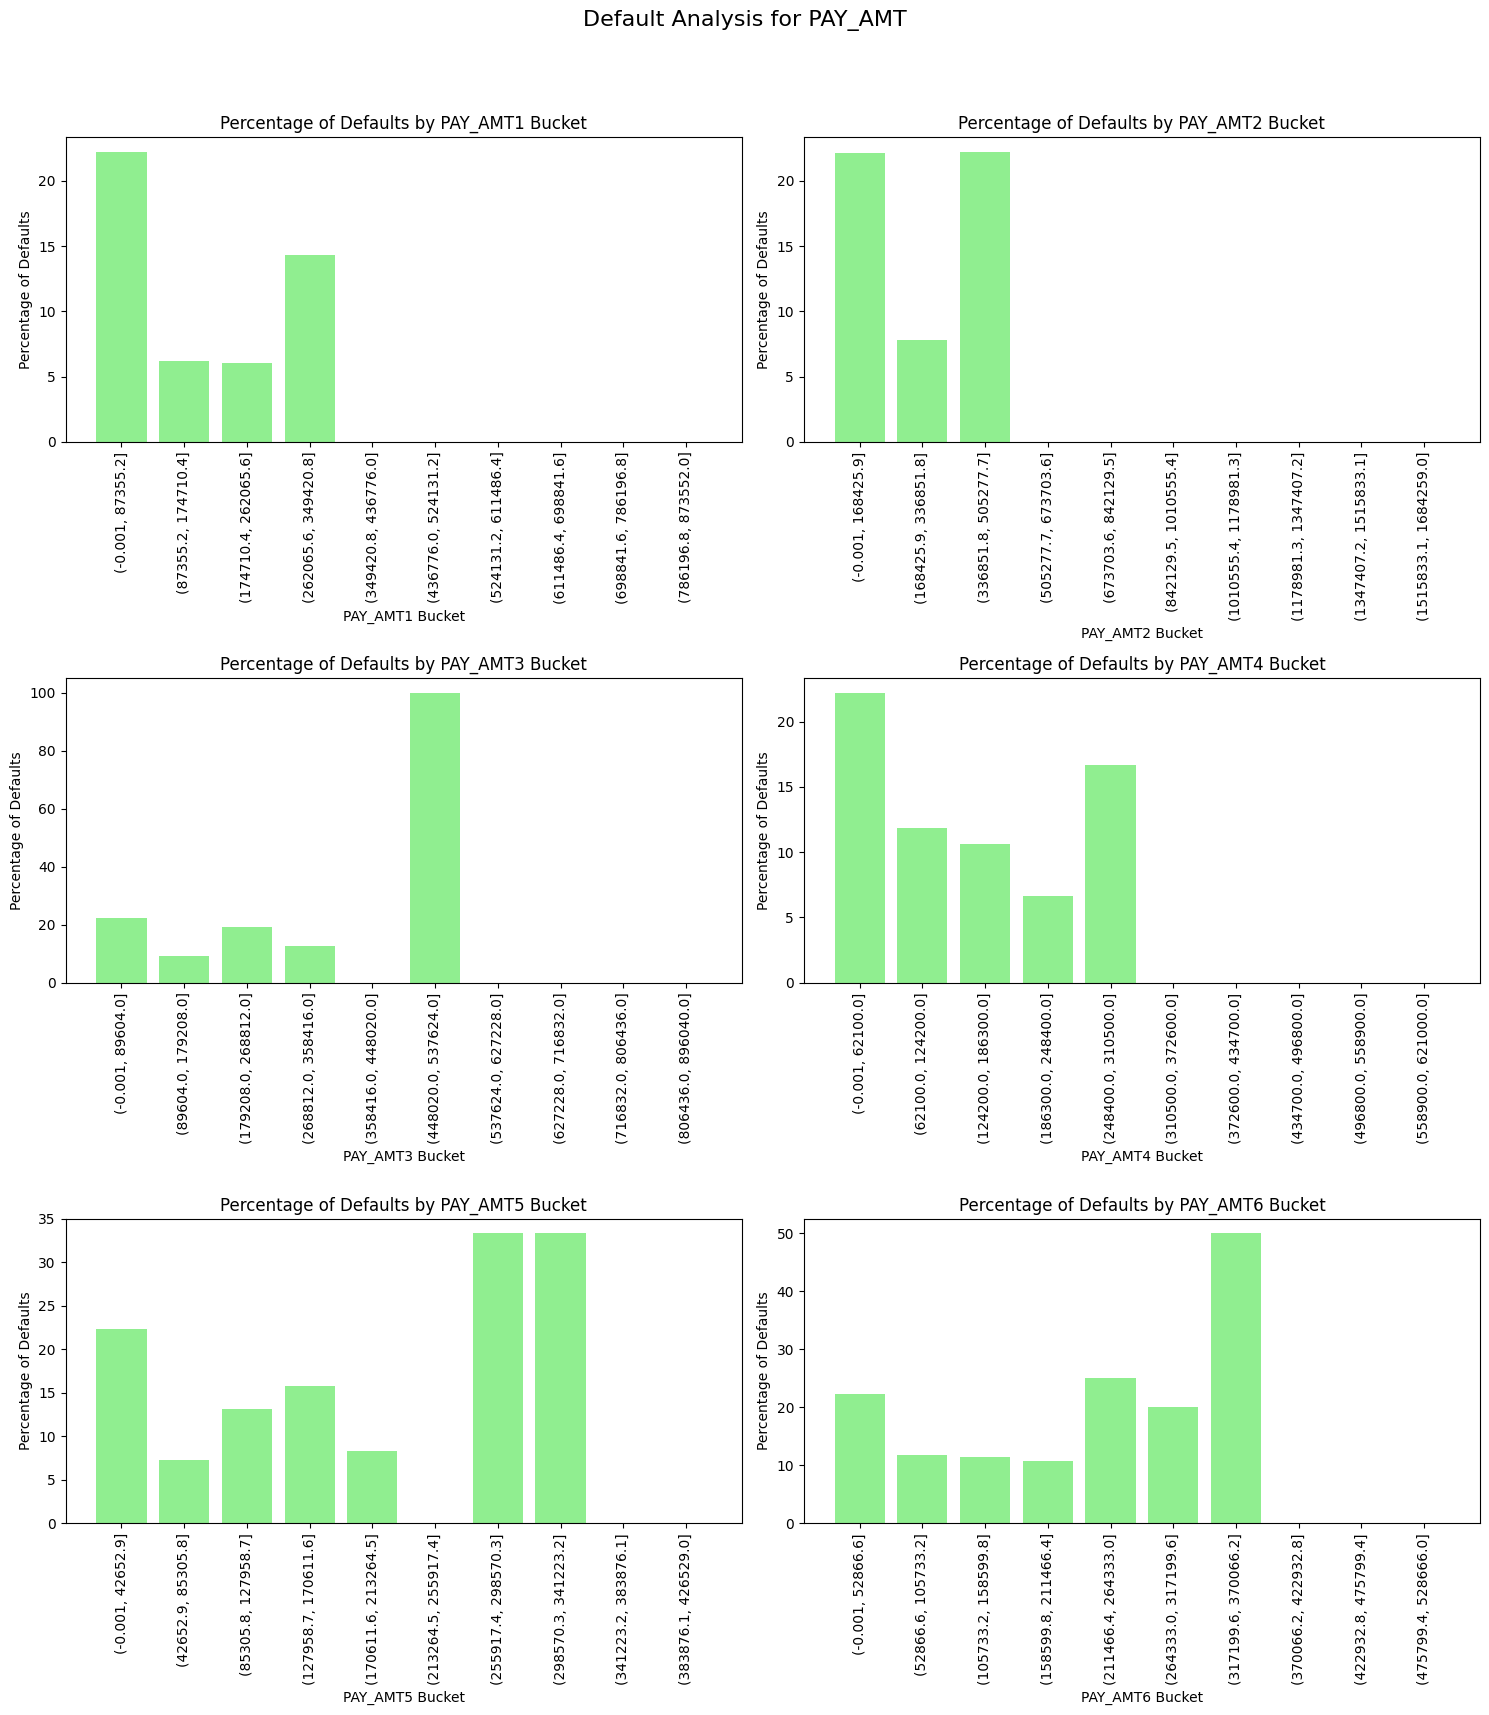

In [15]:
# Create subplots with multiple plots side by side
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('Default Analysis for PAY_AMT', fontsize=16)

# Loop through PAY_AMT columns and create individual bar plots
for i, (amt_col, title) in enumerate(zip(['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
                                         ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])):
    # Define the range for the bins including 0
    min_pay_amt = df[amt_col].min()
    max_pay_amt = df[amt_col].max()
    
    # Create 10 equal bins for the current PAY_AMT column, including 0
    pay_amt_bins = np.linspace(min_pay_amt, max_pay_amt, num=11, endpoint=True)
    
    # Use the cut function to categorize data into the bins for the current PAY_AMT column
    df[f'{amt_col}_Bucket'] = pd.cut(df[amt_col], pay_amt_bins, include_lowest=True)
    
    # Calculate the percentage of defaults within each PAY_AMT bucket
    default_percentages = df.groupby(f'{amt_col}_Bucket')['DEFAULT'].mean() * 100
    
    # Create the bar plot for the current PAY_AMT column
    row, col = divmod(i, 2)
    axes[row, col].bar(default_percentages.index.astype(str), default_percentages, color='lightgreen')
    axes[row, col].set_title(f'Percentage of Defaults by {title} Bucket')
    axes[row, col].set_xlabel(f'{title} Bucket')
    axes[row, col].set_ylabel('Percentage of Defaults')
    axes[row, col].tick_params(axis='x', rotation=90)

# Adjust subplot spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

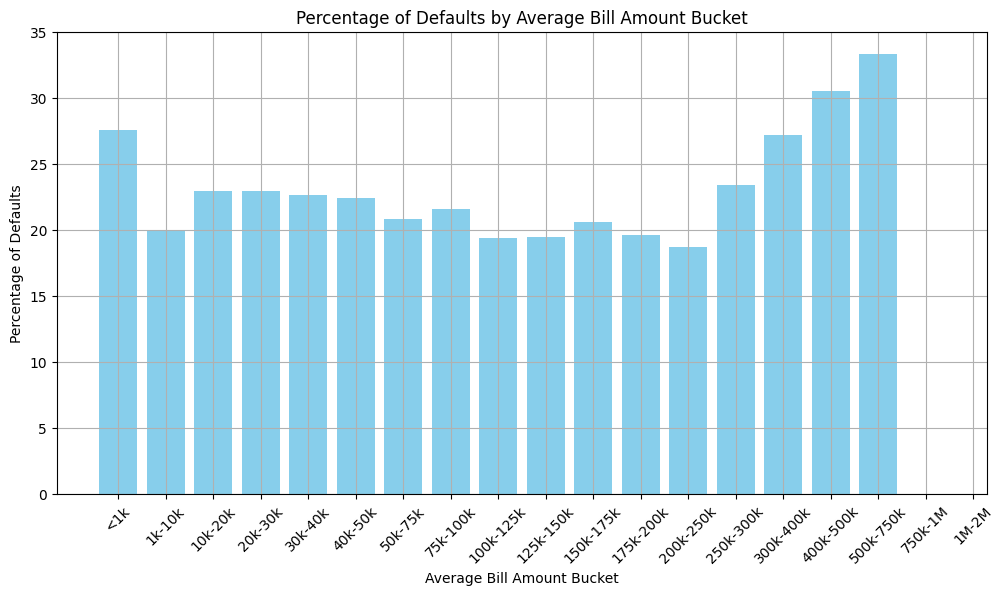

In [16]:
# Assuming you have a DataFrame 'df' with BILL_AMT1 to BILL_AMT6 columns

# Calculate the average bill amount across BILL_AMT1 to BILL_AMT6 for each row
df['Average_Bill_Amount'] = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)

# Define more granular custom bins
custom_bins = [-1, 1000, 10000, 20000, 30000, 40000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 250000, 300000, 400000, 500000, 750000, 1000000, 2000000]

# Use the cut function to categorize data into the custom bins for the average bill amount
df['Average_Bill_Amount_Bucket'] = pd.cut(df['Average_Bill_Amount'], custom_bins, labels=["<1k", "1k-10k", "10k-20k", "20k-30k", "30k-40k", "40k-50k", "50k-75k", "75k-100k", "100k-125k", "125k-150k", "150k-175k", "175k-200k", "200k-250k", "250k-300k", "300k-400k", "400k-500k", "500k-750k", "750k-1M", "1M-2M"], right=False)

# Calculate the percentage of defaults within each average bill amount bucket
default_percentages = df.groupby('Average_Bill_Amount_Bucket')['DEFAULT'].mean() * 100

# Create the bar plot for the percentage of defaults
plt.figure(figsize=(12, 6))
plt.bar(default_percentages.index.astype(str), default_percentages, color='skyblue')
plt.title('Percentage of Defaults by Average Bill Amount Bucket')
plt.xlabel('Average Bill Amount Bucket')
plt.ylabel('Percentage of Defaults')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()

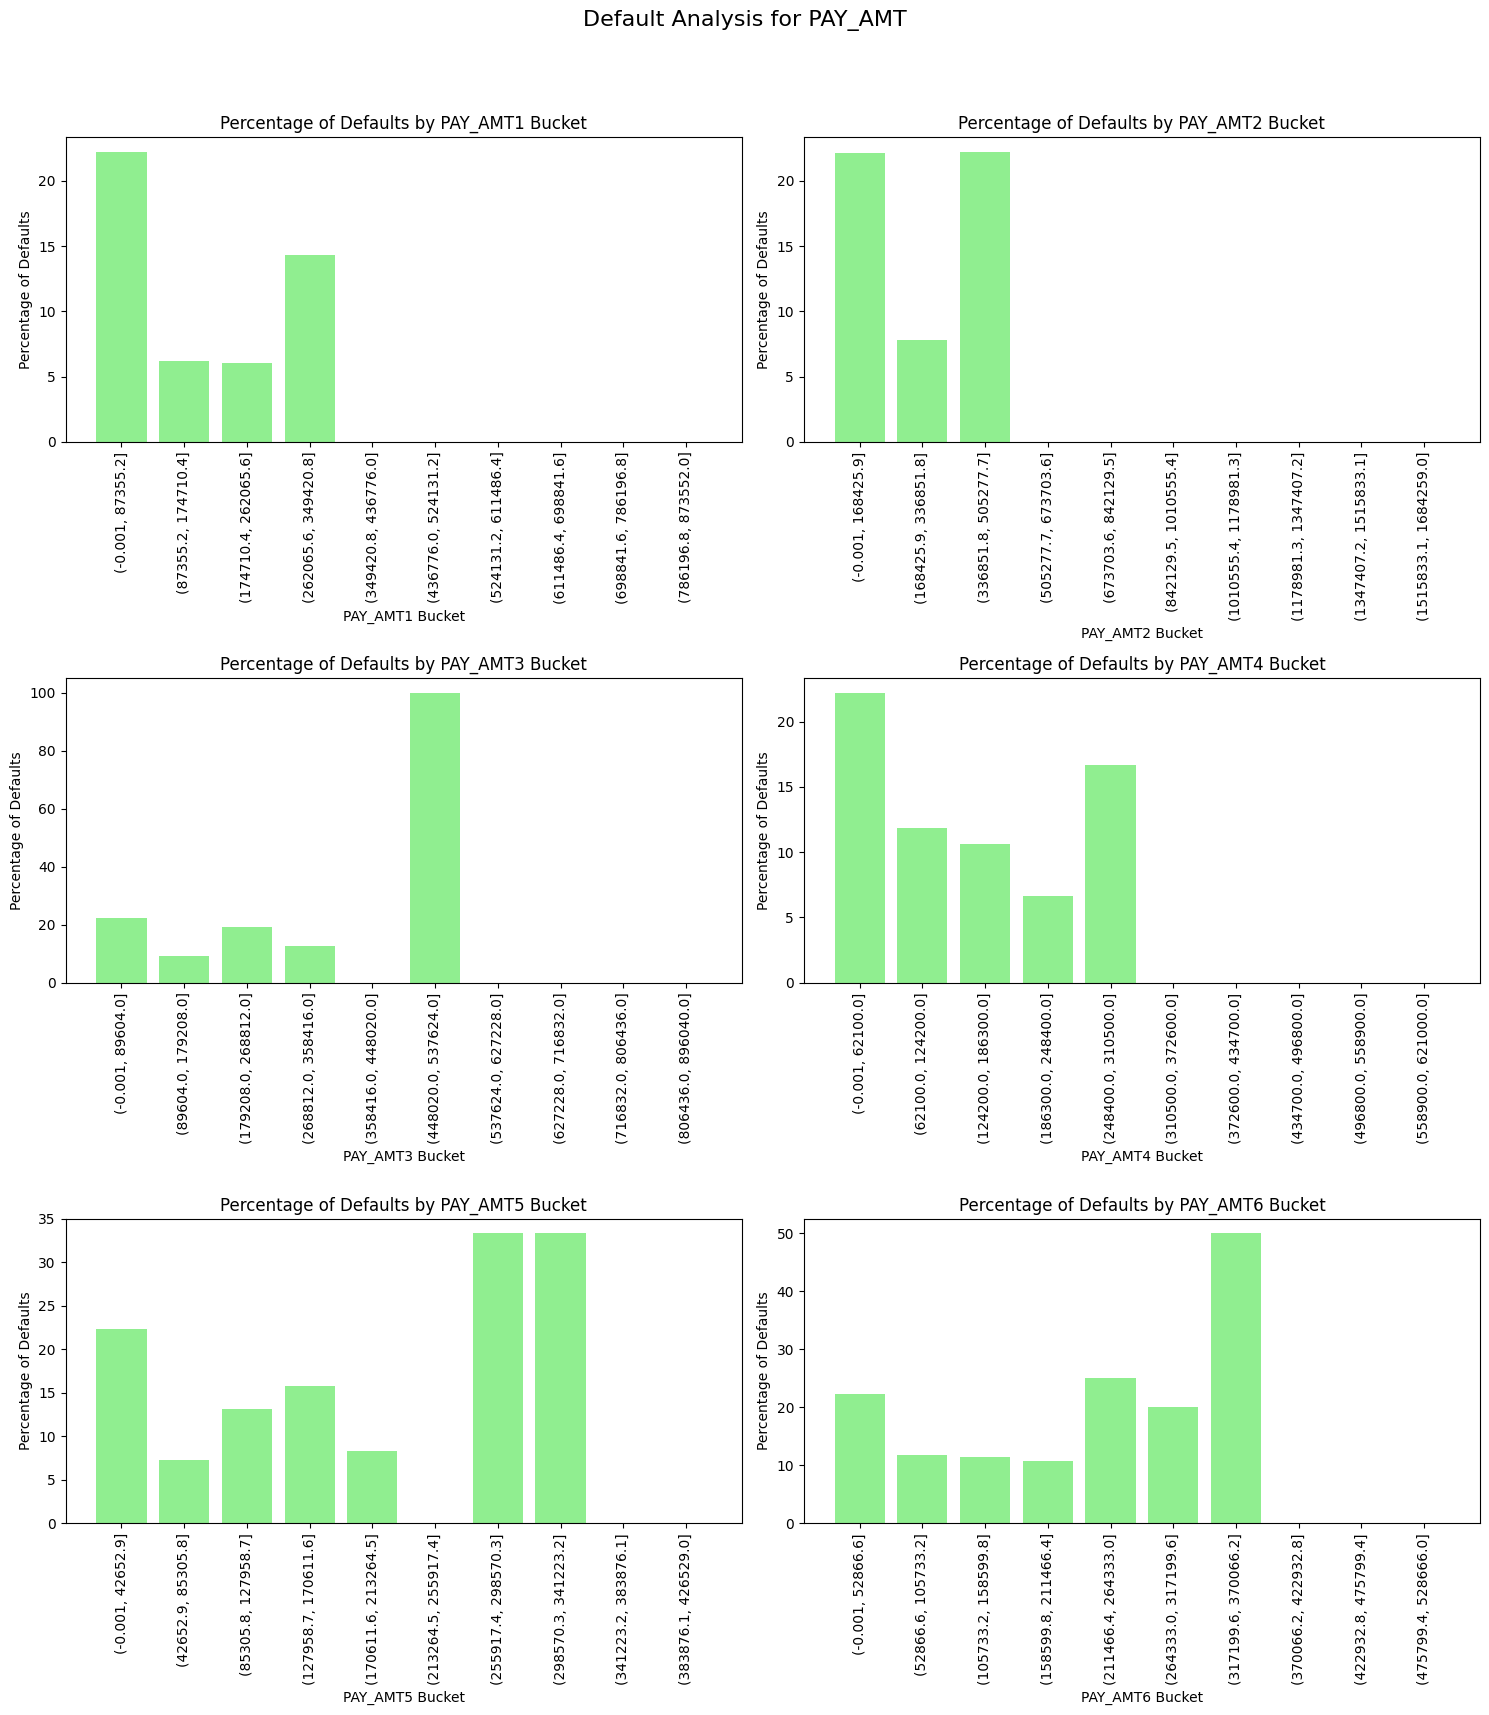

In [17]:
# Create subplots with multiple plots side by side
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('Default Analysis for PAY_AMT', fontsize=16)

# Loop through PAY_AMT columns and create individual bar plots
for i, (amt_col, title) in enumerate(zip(['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
                                         ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])):
    # Define the range for the bins including 0
    min_pay_amt = df[amt_col].min()
    max_pay_amt = df[amt_col].max()
    
    # Create 10 equal bins for the current PAY_AMT column, including 0
    pay_amt_bins = np.linspace(min_pay_amt, max_pay_amt, num=11, endpoint=True)
    
    # Use the cut function to categorize data into the bins for the current PAY_AMT column
    df[f'{amt_col}_Bucket'] = pd.cut(df[amt_col], pay_amt_bins, include_lowest=True)
    
    # Calculate the percentage of defaults within each PAY_AMT bucket
    default_percentages = df.groupby(f'{amt_col}_Bucket')['DEFAULT'].mean() * 100
    
    # Create the bar plot for the current PAY_AMT column
    row, col = divmod(i, 2)
    axes[row, col].bar(default_percentages.index.astype(str), default_percentages, color='lightgreen')
    axes[row, col].set_title(f'Percentage of Defaults by {title} Bucket')
    axes[row, col].set_xlabel(f'{title} Bucket')
    axes[row, col].set_ylabel('Percentage of Defaults')
    axes[row, col].tick_params(axis='x', rotation=90)

# Adjust subplot spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
#Gender vs limit balance and % of default




# Feature Engineering

In [18]:
#Import feature engineered dataset

import os
os.chdir('C:/Users/anton/MMA 867')

path = osp.join(osp.curdir,'Data','6722-credit-card-default-data-FE.xlsx')
df = pd.read_excel(path)

df.head() # show the "head" -- first 5 rows of the data; note, these are rows 0...4


,ID,LIMIT_BAL,LIMIT_BAL_10_30,LIMIT_BAL_30_60,LIMIT_BAL_60_100,LIMIT_BAL_100_200,LIMIT_BAL_200_300,LIMIT_BAL_300_400,LIMIT_BAL_400_500,LIMIT_BAL_500_750,...,BILL_AMT3_MoM,BILL_AMT4_MoM,BILL_AMT5_MoM,PAY_AMT2_MoM,PAY_AMT3_MoM,PAY_AMT4_MoM,PAY_AMT5_MoM,BILL_LIMIT,PAY_LIMIT,PAY_RATIO
0,1,20000,1,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064200,0.005742,0.089434
1,2,90000,0,0,1,0,0,0,0,0,...,-0.053869,-0.041276,-0.038652,0.500000,0.000000,0.000000,-0.800000,0.188246,0.020404,0.108388
2,3,50000,0,1,0,0,0,0,0,0,...,0.740870,-0.022273,-0.019900,0.682500,0.090909,0.028999,0.069000,0.771113,0.027960,0.036259
3,4,50000,0,1,0,0,0,0,0,0,...,0.711318,0.093701,0.000784,2.668100,0.111111,12.062409,0.014728,0.364463,0.196830,0.540054
4,5,50000,0,1,0,0,0,0,0,0,...,1.970403,-0.011468,-0.020226,1.762557,-0.343000,0.000000,0.250000,0.793713,0.025907,0.032640


In [19]:
# Define the bucket ranges and labels
bucket_ranges = [-np.inf, 0, 500000, 600000, np.inf]
bucket_labels = ['LT0', '0_500K', '500K_600K', 'GT600K']

# Columns for which to create dummy variables
bill_amt_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

# Loop through each BILL_AMT column and create dummy variables
for col in bill_amt_columns:
    df[f'BILL_AMT_{col[-1]}'] = pd.cut(df[col], bins=bucket_ranges, labels=bucket_labels, include_lowest=True)
    df = pd.concat([df, pd.get_dummies(df[f'BILL_AMT_{col[-1]}'], prefix=f'BILL_AMT_{col[-1]}')], axis=1)
    df.drop([f'BILL_AMT_{col[-1]}'], axis=1, inplace=True)

# Now, df contains dummy variables for all BILL_AMT columns

In [20]:
# Define bins and labels for PAY_AMT1 through PAY_AMT6
pay_amt_bins = [-np.inf, 0, 100000, 200000, 300000, 400000, 500000, 600000, np.inf]
pay_amt_labels = [
    'LT0', '0_100K', '100K_200K', '200K_300K', '300K_400K', '400K_500K', '500K_600K', 'GT600K'
]

# Loop through PAY_AMT1 to PAY_AMT6 columns and create dummy variables
for i in range(1, 7):
    col_name = f'PAY_AMT{i}'
    df[f'{col_name}_Bucket'] = pd.cut(df[col_name], bins=pay_amt_bins, labels=pay_amt_labels, include_lowest=True)

# Create dummy variables for PAY_AMT1 to PAY_AMT6 buckets
for i in range(1, 7):
    col_name = f'PAY_AMT{i}'
    df = pd.concat([df, pd.get_dummies(df[f'{col_name}_Bucket'], prefix=f'{col_name}')], axis=1)

# Drop the intermediate bucket columns
for i in range(1, 7):
    col_name = f'PAY_AMT{i}_Bucket'
    df.drop(columns=[col_name], inplace=True)

In [21]:
#Feature 4: # Calculate Aggregate statistics
bill_amount_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3','BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
payment_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3','PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
df['BILL_AMT_MEAN'] = df[bill_amount_cols].mean(axis=1)
df['PAY_AMT_MEAN'] = df[payment_cols].mean(axis=1)


#Feature 5
# Define the list of bill amount columns for months 1 to 3 and 4 to 6
bill_months_1_3 = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3']
bill_months_4_6 = ['BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

# Calculate the average percentage change for bill amounts (M1, M2, M3) vs (M4, M5, M6)
df['BILL_AMT_M1_M3_AVG'] = df[bill_months_1_3].mean(axis=1)
df['BILL_AMT_M4_M6_AVG'] = df[bill_months_4_6].mean(axis=1)
df['BILL_AMT_AVG_M1_M3_vs_M4_M6'] = (
    (df['BILL_AMT_M1_M3_AVG'] - df['BILL_AMT_M4_M6_AVG'])
    / df['BILL_AMT_M4_M6_AVG']  
).astype(float)


# Calculate the average percentage change for payment amounts (M1, M2, M3) vs (M4, M5, M6)
payment_months_1_3 = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3']
payment_months_4_6 = ['PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Calculate the average percentage change for payment amounts (M1, M2, M3) vs (M4, M5, M6)
# Calculate the average percentage change for payment amounts (M1, M2, M3) vs (M4, M5, M6)
df['PAY_AMT_M1_M3_AVG'] = df[payment_months_1_3].mean(axis=1)
df['PAY_AMT_M4_M6_AVG'] = df[payment_months_4_6].mean(axis=1)

# Calculate the average percentage change while handling division by zero
df['PAY_AMT_AVG_M1_M3_vs_M4_M6'] = (
    (df['PAY_AMT_M1_M3_AVG'] - df['PAY_AMT_M4_M6_AVG'])
    / df['PAY_AMT_M4_M6_AVG']  # Replace 0 with NaN to handle division by zero
).astype(float)

df = df.replace({True: 1, False: 0})

df.head()

df.replace([np.nan, np.inf, -np.inf], 0, inplace=True)

df.head()

,ID,LIMIT_BAL,LIMIT_BAL_10_30,LIMIT_BAL_30_60,LIMIT_BAL_60_100,LIMIT_BAL_100_200,LIMIT_BAL_200_300,LIMIT_BAL_300_400,LIMIT_BAL_400_500,LIMIT_BAL_500_750,...,PAY_AMT6_500K_600K,PAY_AMT6_GT600K,BILL_AMT_MEAN,PAY_AMT_MEAN,BILL_AMT_M1_M3_AVG,BILL_AMT_M4_M6_AVG,BILL_AMT_AVG_M1_M3_vs_M4_M6,PAY_AMT_M1_M3_AVG,PAY_AMT_M4_M6_AVG,PAY_AMT_AVG_M1_M3_vs_M4_M6
0,1,20000,1,0,0,0,0,0,0,0,...,0,0,1284.000000,114.833333,2568.000000,0.000000,0.000000,229.666667,0.000000,0.000000
1,2,90000,0,0,1,0,0,0,0,0,...,0,0,16942.166667,1836.333333,18941.666667,14942.666667,0.267623,1339.333333,2333.333333,-0.426000
2,3,50000,0,1,0,0,0,0,0,0,...,0,0,38555.666667,1398.000000,48171.333333,28940.000000,0.664524,1739.666667,1056.333333,0.646892
3,4,50000,0,1,0,0,0,0,0,0,...,0,0,18223.166667,9841.500000,16707.333333,19739.000000,-0.153588,16227.000000,3456.000000,3.695312
4,5,50000,0,1,0,0,0,0,0,0,...,0,0,39685.666667,1295.333333,59692.333333,19679.000000,2.033301,1657.333333,933.333333,0.775714


In [22]:
#Male Vs Age Male Vs Edu Feature Engineering
# Create interaction variables for Male and EDUCATION dummies
df['Male_vs_EDU_GRAD'] = df['MALE'] * df['EDU_GRAD']
df['Male_vs_EDU_UNDERGRAD'] = df['MALE'] * df['EDU_UNDERGRAD']
df['Male_vs_EDU_HIGHSCHOOL'] = df['MALE'] * df['EDU_HIGHSCHOOL']
df['Male_vs_EDU_OTHER'] = df['MALE'] * df['EDU_OTHER']
df['Male_vs_EDU_UNKNOWN'] = df['MALE'] * df['EDU_UNKNOWN']

# Create interaction variables for Male and MARRIAGE dummies
df['Male_vs_MARITALSTATUS_MARRIED'] = df['MALE'] * df['MARITALSTATUS_MARRIED']
df['Male_vs_MARITALSTATUS_SINGLE'] = df['MALE'] * df['MARITALSTATUS_SINGLE']
df['Male_vs_MARITALSTATUS_OTHER'] = df['MALE'] * df['MARITALSTATUS_OTHER']

# Create interaction variables for Male and AGE dummies
df['Male_vs_AGE'] = df['MALE'] * df['AGE']
df['Male_vs_AGE_L21'] = df['MALE'] * df['AGE_L21']
df['Male_vs_AGE_21_25'] = df['MALE'] * df['AGE_21_25']
df['Male_vs_AGE_25_30'] = df['MALE'] * df['AGE_25_30']
df['Male_vs_AGE_30_35'] = df['MALE'] * df['AGE_30_35']
df['Male_vs_AGE_35_40'] = df['MALE'] * df['AGE_35_40']
df['Male_vs_AGE_40_45'] = df['MALE'] * df['AGE_40_45']
df['Male_vs_AGE_45_50'] = df['MALE'] * df['AGE_45_50']
df['Male_vs_AGE_50_55'] = df['MALE'] * df['AGE_50_55']
df['Male_vs_AGE_55_60'] = df['MALE'] * df['AGE_55_60']
df['Male_vs_AGE_60_65'] = df['MALE'] * df['AGE_60_65']
df['Male_vs_AGE_65_70'] = df['MALE'] * df['AGE_65_70']
df['Male_vs_AGE_70_75'] = df['MALE'] * df['AGE_70_75']
df['Male_vs_AGE_75_80'] = df['MALE'] * df['AGE_75_80']
df['Male_vs_AGE_GT80'] = df['MALE'] * df['AGE_GT80']

# Step 5:  Defining the vector of target (y) and matrix of features (X)

In [23]:
column_names = df.columns
for name in column_names:
    print(name)

ID
LIMIT_BAL
LIMIT_BAL_10_30
LIMIT_BAL_30_60
LIMIT_BAL_60_100
LIMIT_BAL_100_200
LIMIT_BAL_200_300
LIMIT_BAL_300_400
LIMIT_BAL_400_500
LIMIT_BAL_500_750
LIMIT_BAL_GT750
SEX
MALE
EDUCATION
EDU_GRAD
EDU_UNDERGRAD
EDU_HIGHSCHOOL
EDU_OTHER
EDU_UNKNOWN
MARRIAGE
MARITALSTATUS_MARRIED
MARITALSTATUS_SINGLE
MARITALSTATUS_OTHER
AGE
AGE_L21
AGE_21_25
AGE_25_30
AGE_30_35
AGE_35_40
AGE_40_45
AGE_45_50
AGE_50_55
AGE_55_60
AGE_60_65
AGE_65_70
AGE_70_75
AGE_75_80
AGE_GT80
PAY_1
PAY_2
PAY_3
PAY_4
PAY_5
PAY_6
PAY_1_NEG012
PAY_2_NEG012
PAY_3_NEG012
PAY_4_NEG012
PAY_5_NEG012
PAY_6_NEG012
PAY_1_1
PAY_2_1
PAY_3_1
PAY_1_234
PAY_1_GT4
PAY_2_2345
PAY_2_GT5
PAY_3_23456
PAY_3_GT6
PAY_4_23456
PAY_5_23456
PAY_6_23456
PAY_4_GT6
PAY_5_GT6
PAY_6_GT6
Repayment_Status_NEG012
Repayment_Status_1
Repayment_Status_234
Repayment_Status_GT4
BILL_AMT1
BILL_AMT2
BILL_AMT3
BILL_AMT4
BILL_AMT5
BILL_AMT6
PAY_AMT1
PAY_AMT2
PAY_AMT3
PAY_AMT4
PAY_AMT5
PAY_AMT6
DEFAULT
BILL_LIMIT1
BILL_LIMIT2
BILL_LIMIT3
BILL_LIMIT4
BILL_LIMIT5
BILL_L

In [33]:
#Iterating between variable group selection based on susbequent performance in models - Iterative process
y = df['DEFAULT']
X = df.drop(columns=['DEFAULT', 'ID','LIMIT_BAL',
    'LIMIT_BAL_GT750',
    'SEX',
    'EDUCATION',
    'EDU_UNKNOWN',
    'MARITALSTATUS_OTHER',
    'AGE_L21',
'AGE_21_25',
'AGE_25_30',
'AGE_30_35',
'AGE_35_40',
'AGE_40_45',
'AGE_45_50',
'AGE_50_55',
'AGE_55_60',
'AGE_60_65',
'AGE_65_70',
'AGE_70_75',
'AGE_75_80',
'AGE_GT80',
    'AGE_GT80',
    'PAY_1',
    'PAY_2',
    'PAY_3',
    'PAY_4',
    'PAY_5',
    'PAY_6',
    'BILL_AMT1',
    'BILL_AMT2',
    'BILL_AMT3',
    'BILL_AMT4',
    'BILL_AMT5',
    'BILL_AMT6',
    'BILL_AMT2_MoM',
    'BILL_AMT3_MoM',
    'BILL_AMT4_MoM',
    'BILL_AMT5_MoM',
    'PAY_AMT2_MoM',
    'PAY_AMT3_MoM',
    'PAY_AMT4_MoM',
    'PAY_AMT5_MoM',
    'PAY_AMT1_GT600K',
    'PAY_AMT2_GT600K',
    'PAY_AMT3_GT600K',
    'PAY_AMT4_GT600K',
    'PAY_AMT5_GT600K',
    'PAY_AMT6_GT600K',
    'BILL_AMT_MEAN',
    'PAY_AMT_MEAN',
    'BILL_AMT_M1_M3_AVG',
    'BILL_AMT_M4_M6_AVG',
    'BILL_AMT_AVG_M1_M3_vs_M4_M6',
    'PAY_AMT_M1_M3_AVG',
    'PAY_AMT_M4_M6_AVG',
    'PAY_AMT_AVG_M1_M3_vs_M4_M6',
    'PAY_AMT1',
    'PAY_AMT2' ,                   
    'PAY_AMT3',
    'PAY_AMT4',
    'PAY_AMT5',      
    'PAY_AMT6',
'PAY_LIMIT1',
'PAY_LIMIT2',
'PAY_LIMIT3',
'PAY_LIMIT4',
'PAY_LIMIT5',
'PAY_LIMIT6',
'BILL_LIMIT1',
'BILL_LIMIT2',
'BILL_LIMIT3',
'BILL_LIMIT4',
'BILL_LIMIT5',
'BILL_LIMIT6',
'PAY_RATIO_1',
'PAY_RATIO_2',
'PAY_RATIO_3',
'PAY_RATIO_4',
'PAY_RATIO_5',
'PAY_RATIO_6',
'Repayment_Status_NEG012',
'Repayment_Status_1',
'Repayment_Status_234',
'Repayment_Status_GT4','Male_vs_EDU_GRAD',
'Male_vs_EDU_UNDERGRAD',
'Male_vs_EDU_HIGHSCHOOL',
'Male_vs_EDU_OTHER',
'Male_vs_EDU_UNKNOWN',
'Male_vs_MARITALSTATUS_MARRIED',
'Male_vs_MARITALSTATUS_SINGLE',
'Male_vs_MARITALSTATUS_OTHER',
'Male_vs_AGE',
'Male_vs_AGE_L21',
'Male_vs_AGE_21_25',
'Male_vs_AGE_25_30',
'Male_vs_AGE_30_35',
'Male_vs_AGE_35_40',
'Male_vs_AGE_40_45',
'Male_vs_AGE_45_50',
'Male_vs_AGE_50_55',
'Male_vs_AGE_55_60',
'Male_vs_AGE_60_65',
'Male_vs_AGE_65_70',
'Male_vs_AGE_70_75',
'Male_vs_AGE_75_80',
'Male_vs_AGE_GT80'])

# Step 6:  Splitting X and y into training and testing

In [34]:
# For "apples-to-apples" comparisons, set a starting value ("seed") for the random number generator
np.random.seed(77300)

# split the data randomly into 90% train and 10% test samples
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.10, stratify=y)
# IMPORTANT: these samples are stratified, i.e., the proportion of retained and not-retained customers is the same in both

# Lets check the results
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21600, 107)
(2400, 107)
(21600,)
(2400,)


# Steps 7, 8, 9: Train a model on the training data, Use it to predict the values in the testing data, Compute the metrics of the model and compare models

In [35]:
# First we define a set of functions to compute the metrics of the model

# ROC curve
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1, drop_intermediate = False)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel('1-Specificity (False Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix returns in the format: cm[0,0], cm[0,1], cm[1,0], cm[1,1]: tn, fp, fn, tp

# Sensitivity
def custom_sensitivity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fn))

# Specificity
def custom_specificity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fp))

# Positive Predictive Value
def custom_ppv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fp))

# Negative Predictive Value
def custom_npv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fn))

# Accuracy
def custom_accuracy_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return ((tn+tp)/(tn+tp+fn+fp))

# Define a function to calculate the objective function
def calculate_objective_function(TN, FP, FN, TP):
    return TN * 1500 - FN * 5000 - 1500 * FP + TP * 0

# Model №1: Logistic regression


In [36]:
# define the model and call it classifier_LR
classifier_LR = LogisticRegression(solver='liblinear')

# train classifier_LR on the training data
classifier_LR.fit(X_train, y_train)

# This is a regression, so it has coefficients -- lets see them
# Note, there is no easy way to show significance, etc. with sklearn
print('Intercept: ' + str(classifier_LR.intercept_))
print('Coefficients (10 largest and 10 smallest) [recall, there are 252 of them, in total: ')
summary = pd.DataFrame([X_test.columns,classifier_LR.coef_[0]]).transpose().sort_values(by = 1, ascending = False)
summary.columns = ['Variable','Coefficient']
top10positive = summary.head(10) # 10 largest (by value)
top10negative = summary.tail(10) # 10 smallest (by value)
# Append the DataFrames
top10list = pd.concat([top10positive, top10negative])
top10list


Intercept: [-0.02420315]
Coefficients (10 largest and 10 smallest) [recall, there are 252 of them, in total: 


,Variable,Coefficient
26,PAY_1_234,0.693511
28,PAY_2_2345,0.237911
38,BILL_LIMIT,0.222503
34,PAY_6_23456,0.157507
0,LIMIT_BAL_10_30,0.155574
30,PAY_3_23456,0.143443
33,PAY_5_23456,0.126297
1,LIMIT_BAL_30_60,0.121551
79,PAY_AMT3_LT0,0.118325
32,PAY_4_23456,0.111653


In [40]:
# Use the trained model to predict testing data

y_pred_prob = classifier_LR.predict_proba(X_test)[:,1] # probabilities

# Select the threshold value -- First threshold of existing default rate in training data passed
class_threshold = 0.3333333333333333

y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # applying the threshold rule to classify

print(y_pred_prob[0:5]) # first 5 probabilities
print(y_pred[0:5]) # resultant predicted classification
print(y_test[0:5]) # actual outcomes


[0.16482945 0.14875091 0.65259404 0.16654904 0.10413507]
[0 0 1 0 0]
1348     0
14102    0
14945    0
3656     0
23103    0
Name: DEFAULT, dtype: int64


Metrics of the logistic regression model: 

Confusion matrix: 
[[1716  153]
 [ 272  259]]
                                   Accuracy: 0.8229166666666666
                   SENSITIVITY (aka RECALL): 0.487758945386064
                 SPECIFICITY (aka FALL-OUT): 0.9181380417335474
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.6286407766990292
                 NEGATIVE PREDICTIVE VALUE): 0.8631790744466801


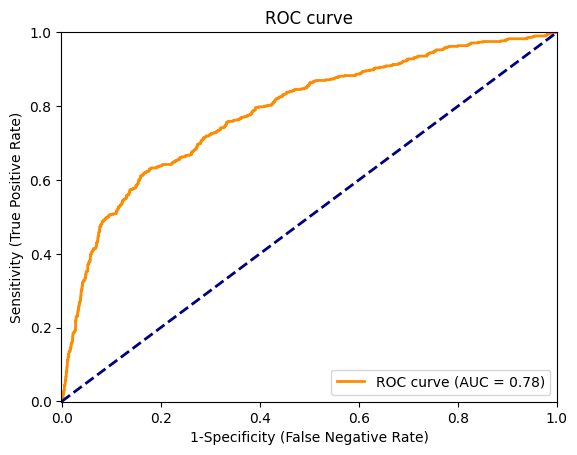

 AUC: 0.7849550450959706
Test Profit Value: 984500


In [41]:
# Lets look at the model metrics
print('Metrics of the logistic regression model: \n')

cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

# Calculate the objective function   
test_profit_value = calculate_objective_function(cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1])
print("Test Profit Value: " + str(test_profit_value))

In [39]:
##Threshold optimization code for maximizing profit

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Define the confusion matrix function
def compute_confusion_matrix(threshold, y_true, y_prob):
    y_pred = (y_prob > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    return cm

# Define the objective function to maximize
def objective_function(threshold, y_true, y_prob):
    cm = compute_confusion_matrix(threshold, y_true, y_prob)
    TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    return TN * 1500 - FN * 5000 - 1500 * FP + TP * 0
    
# Set a range of threshold values to search within
threshold_values = np.linspace(0, 1, 1000)

# Initialize variables to track the best threshold and maximum objective function value
best_threshold = 0
max_objective_value = float('-inf')

# Iterate through the threshold values to find the maximum
for threshold in threshold_values:
    objective_value = objective_function(threshold, y_test, y_pred_prob)
    if objective_value > max_objective_value:
        max_objective_value = objective_value
        best_threshold = threshold

# Use the best threshold to classify
y_pred_optimized = (y_pred_prob > best_threshold).astype(int)

# Print the optimized threshold, classification results, and objective function value
print("Best Threshold:", best_threshold)
print("Optimized Confusion Matrix:")
print(compute_confusion_matrix(best_threshold, y_test, y_pred_prob))
print("Maximized Objective Function Value:", max_objective_value)

Best Threshold: 0.3333333333333333
Optimized Confusion Matrix:
[[1716  153]
 [ 272  259]]
Maximized Objective Function Value: 984500


In [42]:
# Apply variable selection with Stepwise Recursive Feature Selection

from sklearn.feature_selection import RFE

rfe = RFE(estimator=classifier_LR, n_features_to_select=30, step=1) # in this example we will select 20 variables; this number "20" is a hyperparameter to tune
rfe.fit(X_train, y_train)
ranking = rfe.ranking_.reshape(len(X_train.columns))

# which 20 variables are in the model?
pd.DataFrame([X_test.columns,ranking]).transpose().sort_values(1).head(30)

,0,1
0,LIMIT_BAL_10_30,1
19,PAY_3_NEG012,1
65,PAY_AMT1_LT0,1
21,PAY_5_NEG012,1
55,BILL_AMT_4_500K_600K,1
23,PAY_1_1,1
24,PAY_2_1,1
35,PAY_4_GT6,1
51,BILL_AMT_3_500K_600K,1
47,BILL_AMT_2_500K_600K,1


Metrics of the logistic regression model after variable selection: 

Confusion matrix: 
[[1589  280]
 [ 228  303]]
                                   Accuracy: 0.7883333333333333
                   SENSITIVITY (aka RECALL): 0.5706214689265536
                 SPECIFICITY (aka FALL-OUT): 0.850187265917603
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.5197255574614065
                 NEGATIVE PREDICTIVE VALUE): 0.8745184369840396


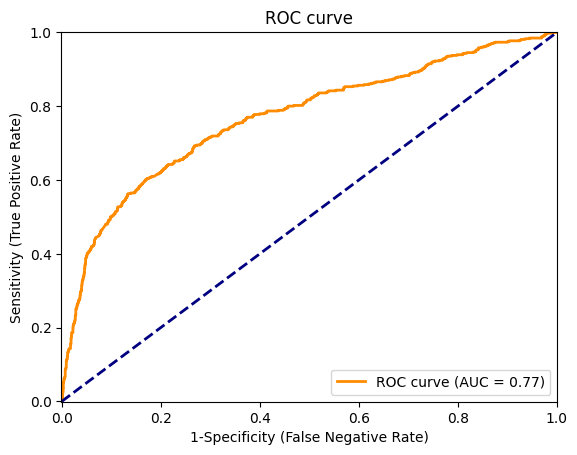

 AUC: 0.7681182420279735
Test Profit Value: 823500


In [44]:
# Train the model and call it classifier_LR_RFE
classifier_LR_RFE = rfe.fit(X_train, y_train)

# Use the trained model to predict testing data
y_pred_prob = classifier_LR_RFE.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > 0.23, 1, 0) # classification

# Lets look at the model metrics after variable selection
print('Metrics of the logistic regression model after variable selection: \n')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

# Calculate the objective function
# Define a function to calculate the objective function
def calculate_objective_function(TN, FP, FN, TP):
    return TN * 1500 - FN * 5000 - 1500 * FP + TP * 0
    
test_profit_value = calculate_objective_function(cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1])
print("Test Profit Value: " + str(test_profit_value))

In [45]:
# Set a range of threshold values to search within
threshold_values = np.linspace(0, 1, 1000)

# Initialize variables to track the best threshold and maximum objective function value
best_threshold = 0
max_objective_value = float('-inf')

# Iterate through the threshold values to find the maximum
for threshold in threshold_values:
    objective_value = objective_function(threshold, y_test, y_pred_prob)
    if objective_value > max_objective_value:
        max_objective_value = objective_value
        best_threshold = threshold

# Use the best threshold to classify
y_pred_optimized = (y_pred_prob > best_threshold).astype(int)

# Print the optimized threshold, classification results, and objective function value
print("Best Threshold:", best_threshold)
print("Optimized Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimized))
print("Maximized Objective Function Value:", max_objective_value)

Best Threshold: 0.34134134134134136
Optimized Confusion Matrix:
[[1745  124]
 [ 298  233]]
Maximized Objective Function Value: 941500


## Summary for Logistic Regression:

- We first trained the model with the entire set of variables
- When applied to testing data, AUC=63% ,expected profit Value: 1,406,500
- Through variable selection AUC increased to 74%, expected profit = 1,850,500

# Method №2: Classification and Regression Tree, CART (aka "decision tree")

In [46]:
# Define a CART model and call it classifier_DT
classifier_DT = DecisionTreeClassifier(max_leaf_nodes = 5, random_state=77300) # random_state -- is same as random seed, neede to get the same result every time we rerun

# Train the model classifier_DT on the training data
classifier_DT.fit(X_train, y_train)

#  Use the trained model to predict testing data
y_pred_prob = classifier_DT.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

print(y_pred_prob[0:5]) # first 5 probabilities
print(y_pred[0:5]) # resultant predicted classification
print(y_test[0:5]) # actual outcomes

[0.12863414 0.12863414 0.69686099 0.12863414 0.12863414]
[0 0 1 0 0]
1348     0
14102    0
14945    0
3656     0
23103    0
Name: DEFAULT, dtype: int64


CART tree with 5 leafs


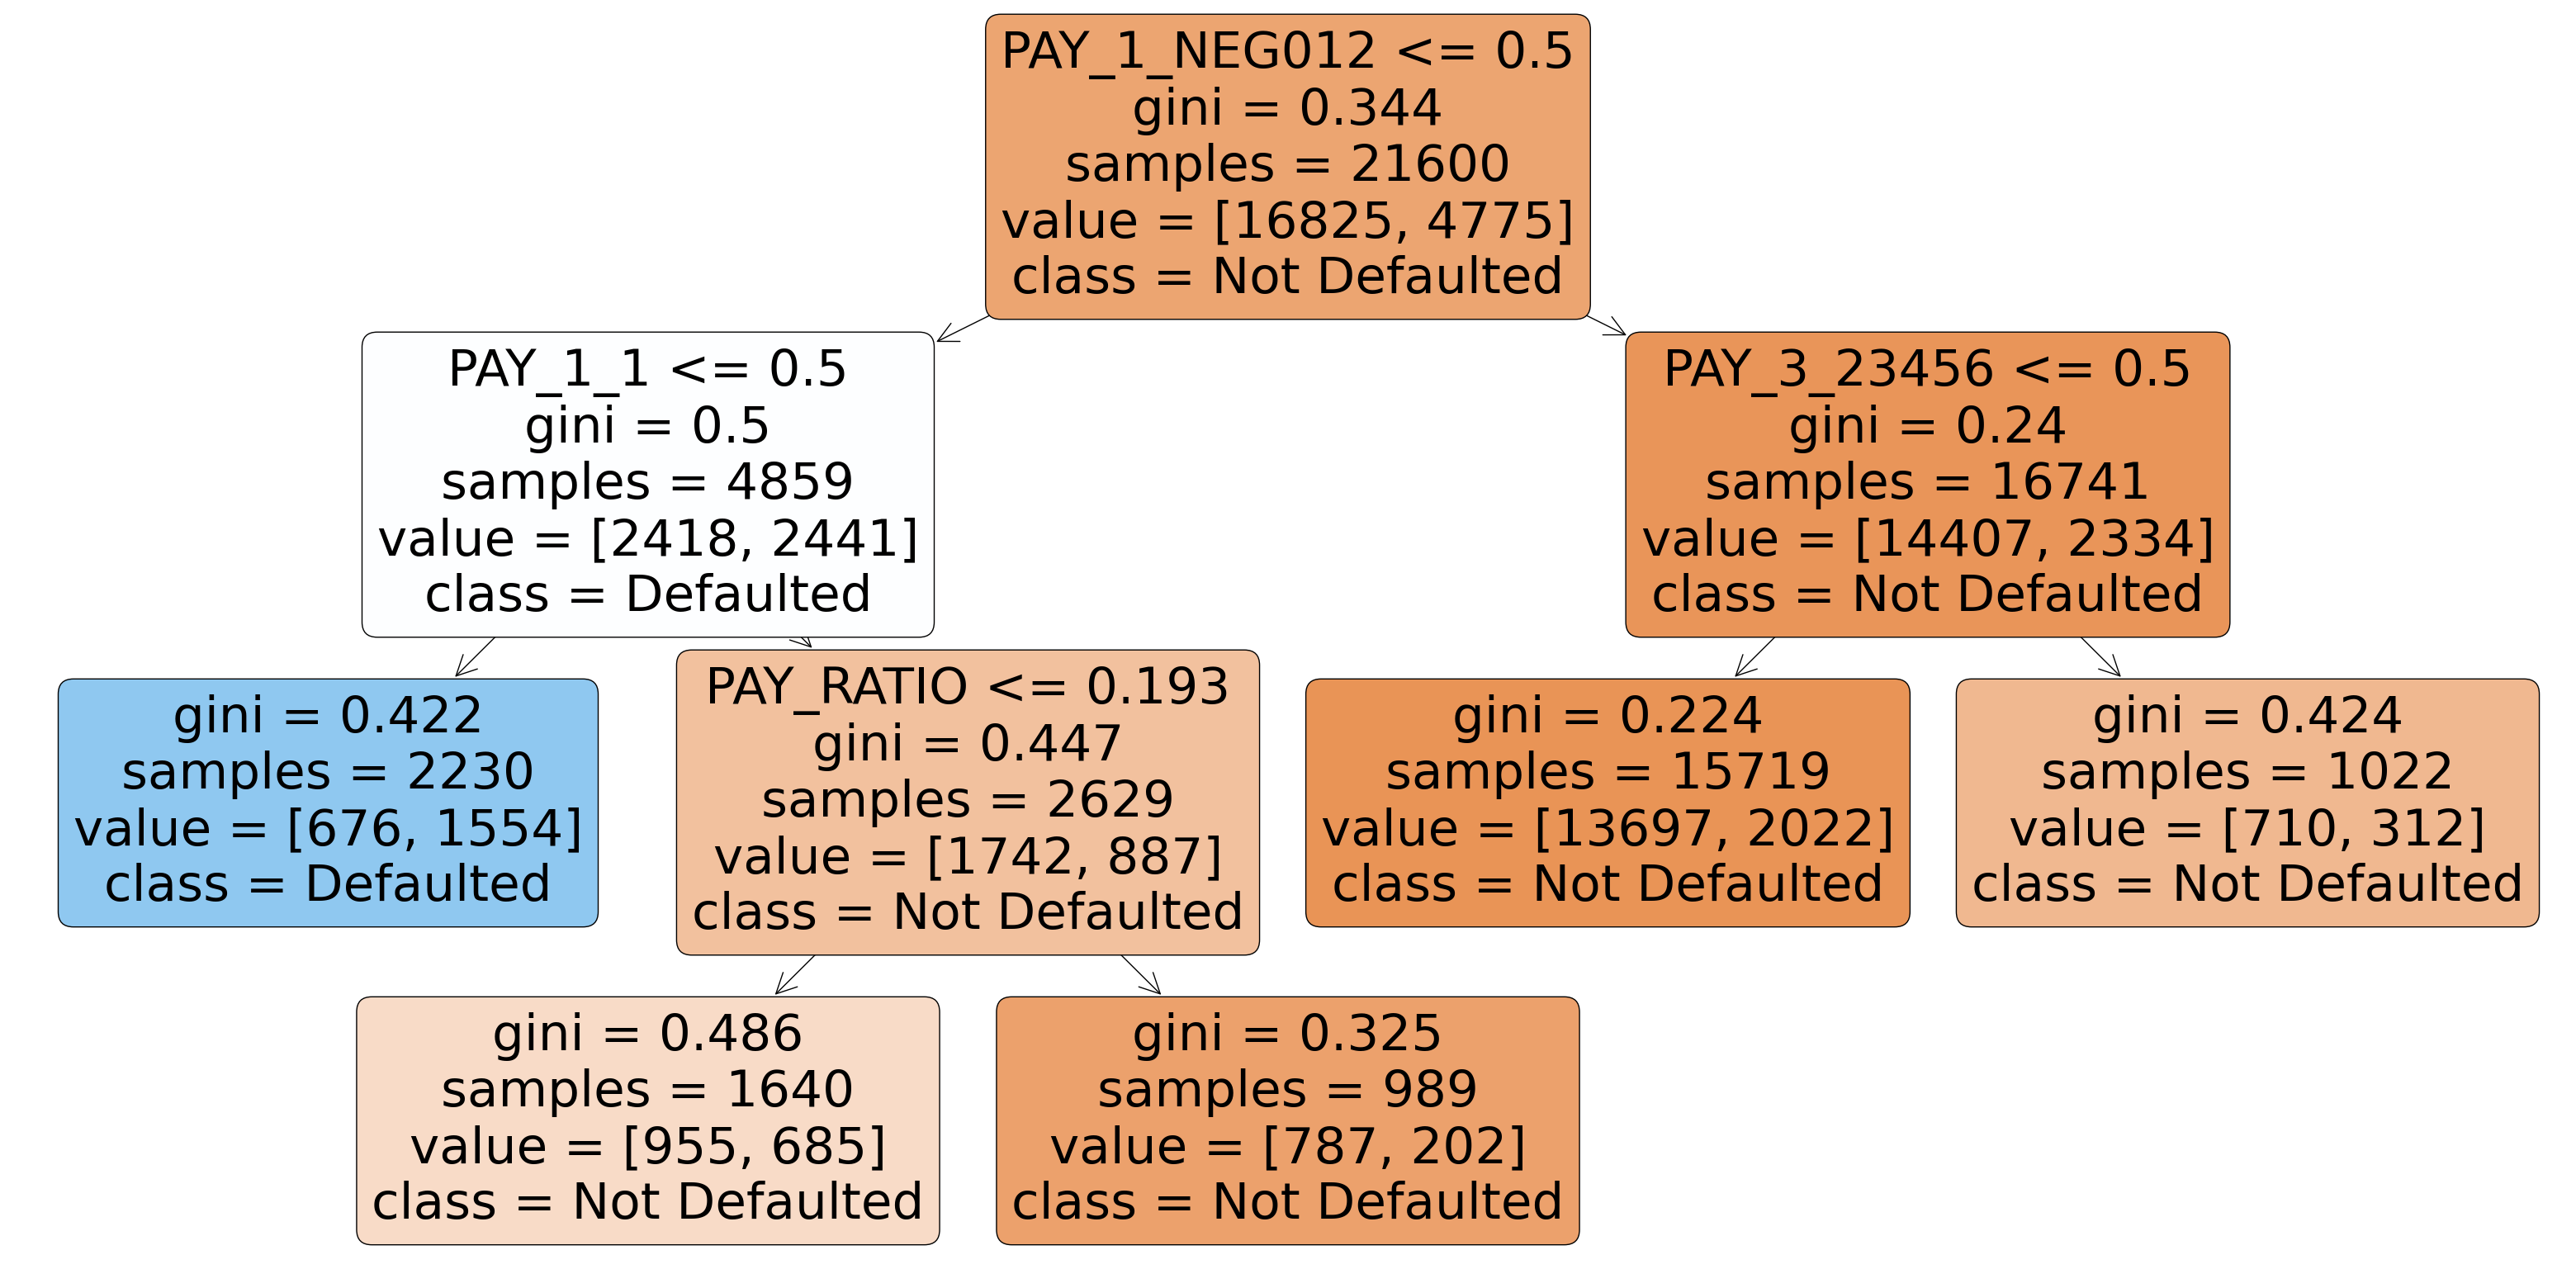

In [47]:
# Visualizing the resultant tree

from sklearn import tree

plt.figure(figsize=(40,20))
tree.plot_tree(classifier_DT.fit(X_train, y_train), feature_names = X_train.columns, filled = True,
               class_names = ['Not Defaulted', 'Defaulted'], rounded = True)
print('CART tree with 5 leafs')

Metrics of the CART model: 

Confusion matrix: 
[[1691  178]
 [ 281  250]]
                                   Accuracy: 0.80875
                   SENSITIVITY (aka RECALL): 0.4708097928436911
                 SPECIFICITY (aka FALL-OUT): 0.9047619047619048
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.5841121495327103
                 NEGATIVE PREDICTIVE VALUE): 0.8575050709939148


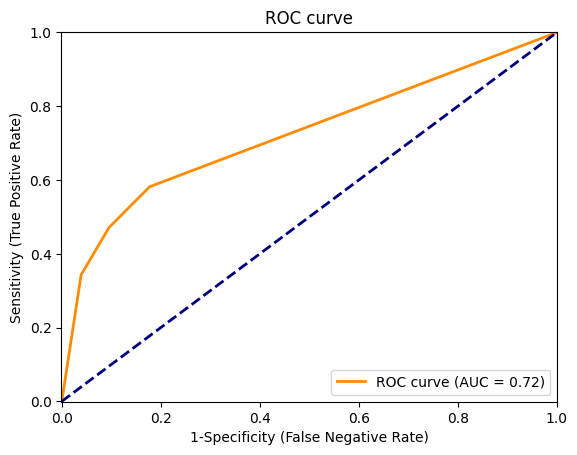

 AUC: 0.7233845102822442
Test Profit Value: 864500


In [48]:
# Lets look at the model metrics

print('Metrics of the CART model: \n')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

#Calculating expected profit value
test_profit_value = calculate_objective_function(cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1])
print("Test Profit Value: " + str(test_profit_value))

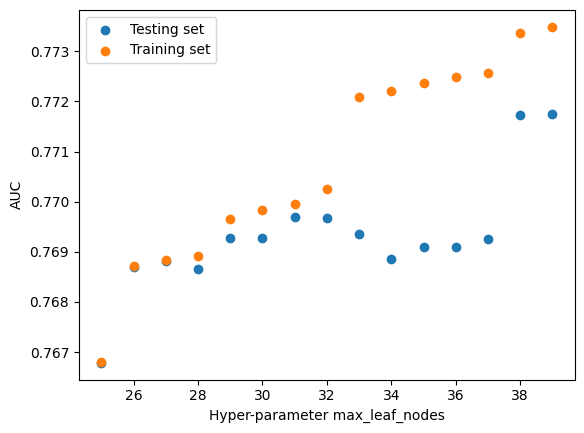

In [53]:
# Tuning hyper-parameter max_leaf_nodes

n_max_leaf_nodes = range(25,40) # Lets train the models with 5, 6, 7, ... 40 leafs

# for each model calculate AUC for testing
array = []
for n in n_max_leaf_nodes:

    classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = n)
    classifier_DT = classifier_DT.fit(X_train, y_train)

    y_pred_prob = classifier_DT.predict_proba(X_test)[:,1]
    y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

    array.append([n,roc_auc_score(y_test, y_pred_prob)])

# plot the testing set AUCs
array = pd.DataFrame(array)
plt.scatter(array[0],array[1])

# now for each model calculate AUC on training
array = []
for n in n_max_leaf_nodes:

    classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = n)
    classifier_DT = classifier_DT.fit(X_train, y_train)

    y_pred_prob = classifier_DT.predict_proba(X_train)[:,1]
    y_pred = np.where(y_pred_prob > 0.23, 1, 0)

    array.append([n,roc_auc_score(y_train, y_pred_prob)])

# plot the training set AUCs
array = pd.DataFrame(array)
plt.scatter(array[0],array[1])

# label the axes on the plot
plt.xlabel('Hyper-parameter max_leaf_nodes')
plt.ylabel('AUC')

# add the legend
plt.legend(['Testing set','Training set'])

## This plot illustrates the concept of "overfitting":  

- At around 32 leafs, the AUC for both train and test datasets are similar. Beyond that the model faces the risk of overfitting

Metrics of the CART model: 

Confusion matrix: 
[[1579  290]
 [ 227  304]]
                                   Accuracy: 0.7845833333333333
                   SENSITIVITY (aka RECALL): 0.5725047080979284
                 SPECIFICITY (aka FALL-OUT): 0.8448368111289459
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.5117845117845118
                 NEGATIVE PREDICTIVE VALUE): 0.8743078626799557


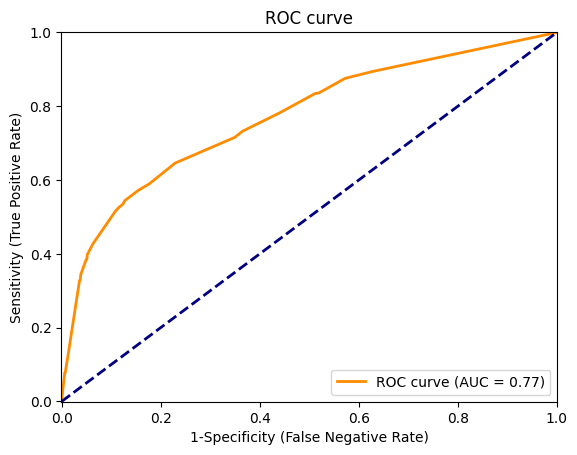

 AUC: 0.7696704784878465
Test Profit Value: 798500
CART tree with 32 leafs


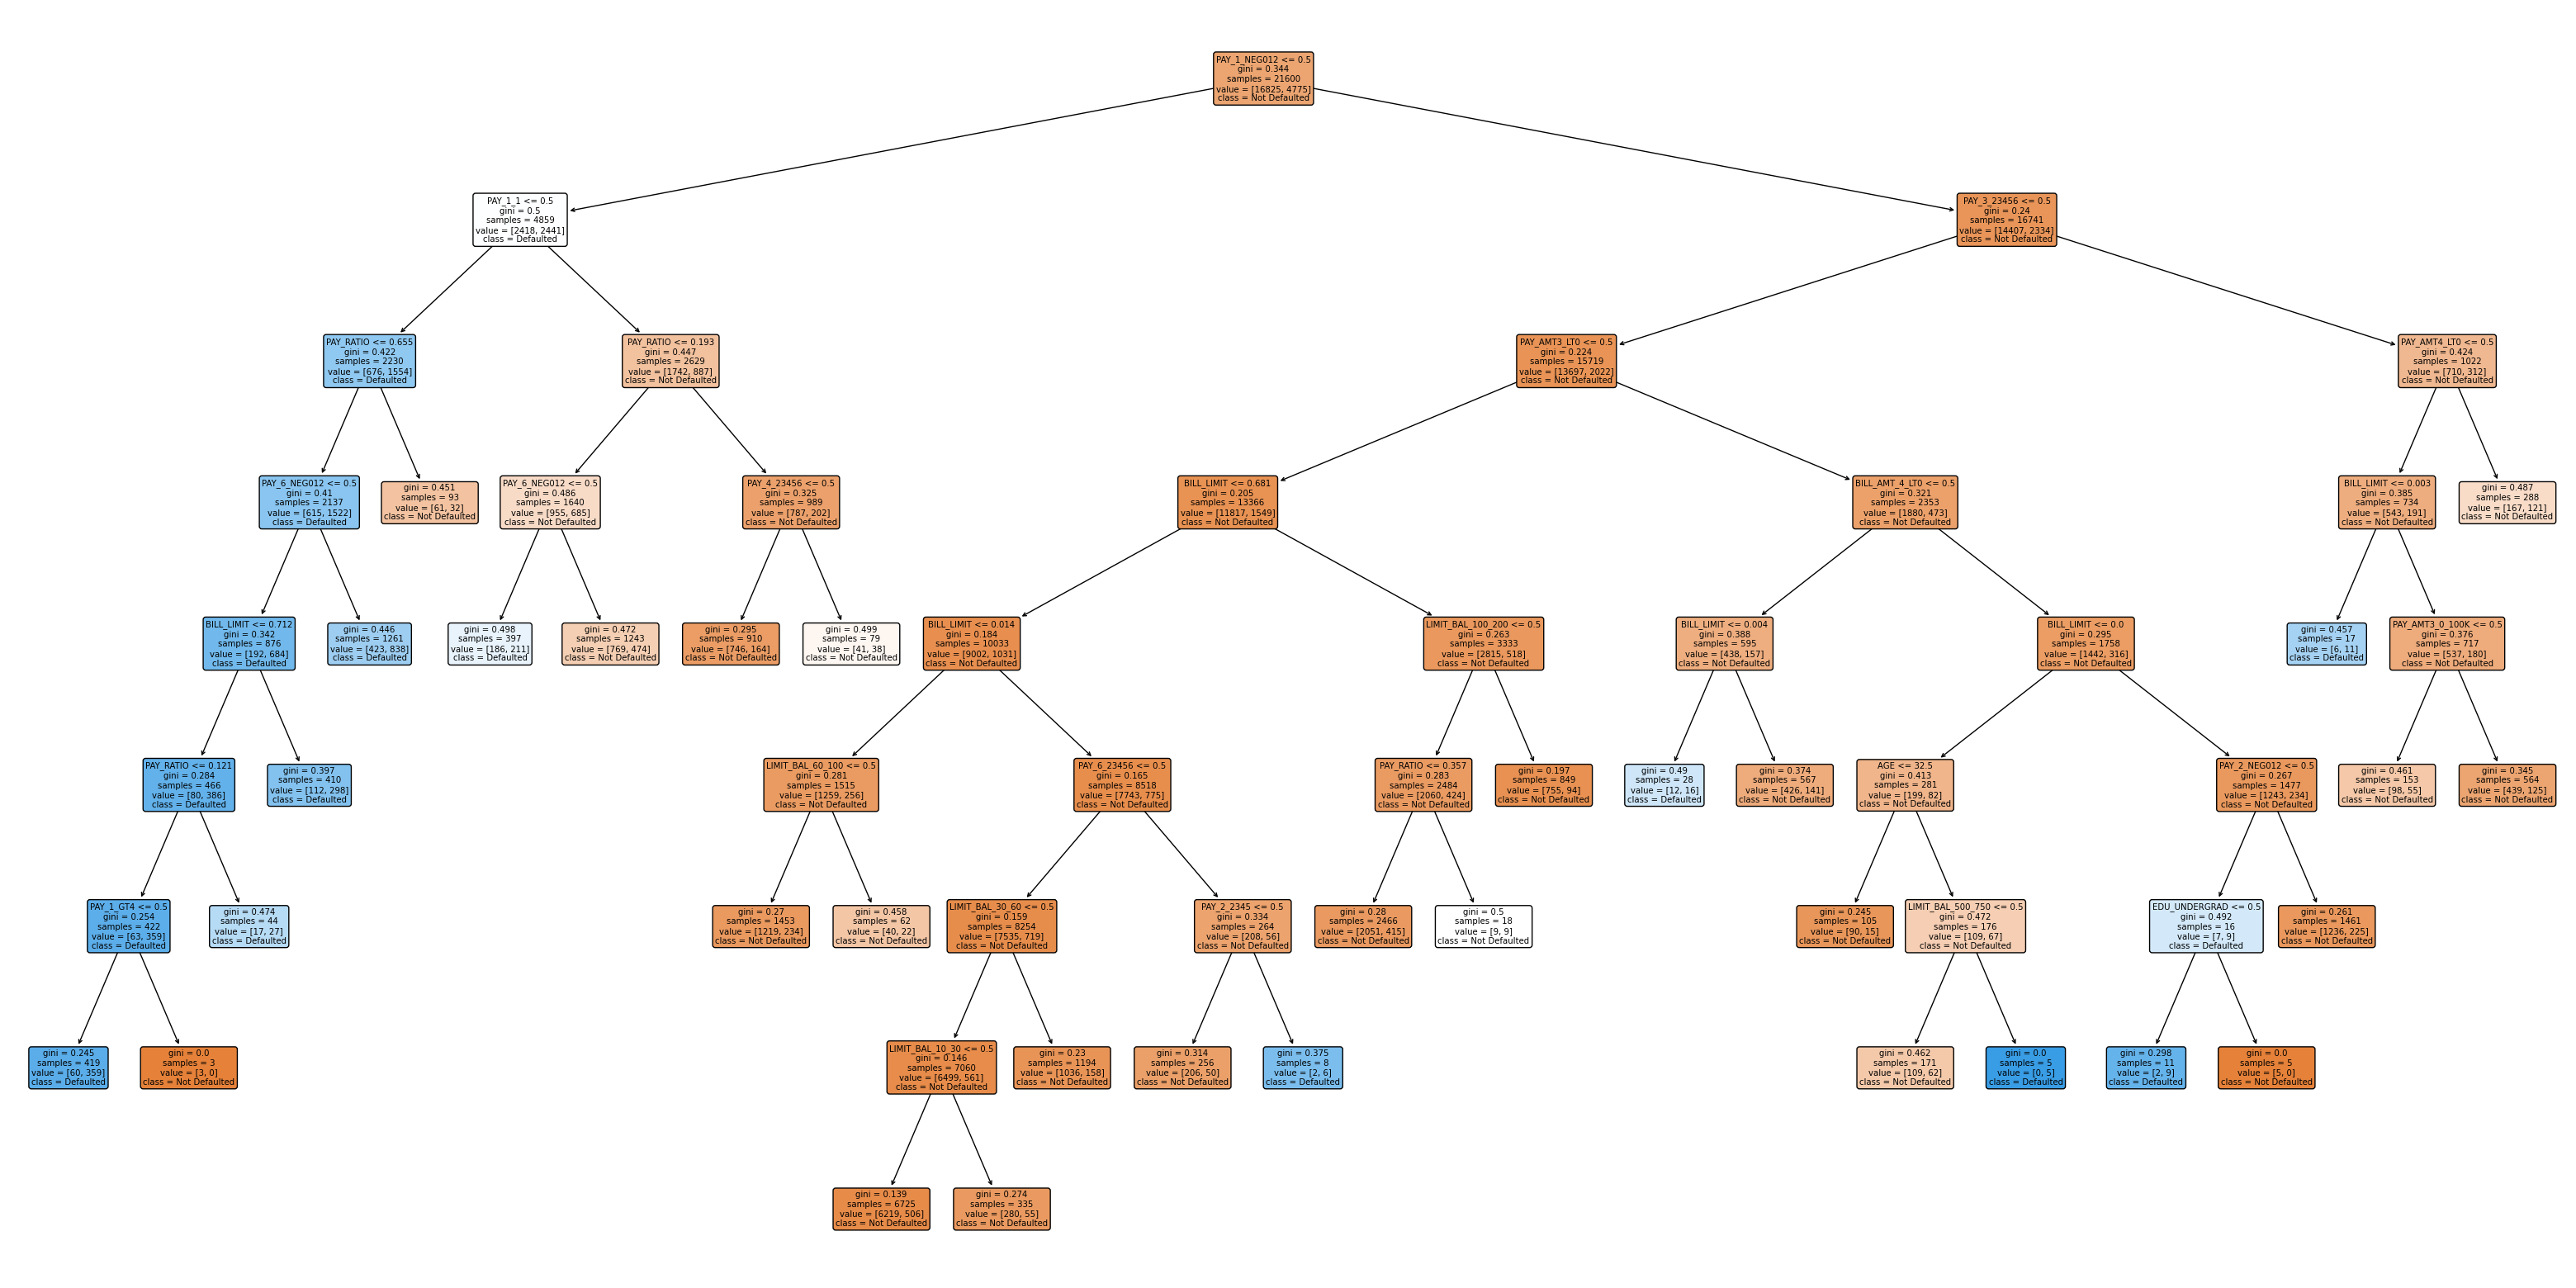

In [28]:
# Re-running the model with 32 leaves
classifier_DT = DecisionTreeClassifier(max_leaf_nodes = 32, random_state=77300) # random_state -- is same as random seed, neede to get the same result every time we rerun

# Train the model classifier_DT on the training data
classifier_DT.fit(X_train, y_train)

#  Use the trained model to predict testing data
y_pred_prob = classifier_DT.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > 0.23, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the CART model: \n')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

#Calculating expected profit value
test_profit_value = calculate_objective_function(cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1])
print("Test Profit Value: " + str(test_profit_value))

# Visualizing the resultant tree

from sklearn import tree

plt.figure(figsize=(40,20))
tree.plot_tree(classifier_DT.fit(X_train, y_train), feature_names = X_train.columns, filled = True,
               class_names = ['Not Defaulted', 'Defaulted'], rounded = True)
print('CART tree with 32 leafs')

In [29]:
import numpy as np
from scipy.optimize import minimize_scalar
from sklearn.metrics import confusion_matrix

# Define the confusion matrix function
def compute_confusion_matrix(threshold, y_true, y_prob):
    y_pred = (y_prob > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    return cm

# Define the objective function to maximize
def objective_function(threshold, y_true, y_prob):
    cm = compute_confusion_matrix(threshold, y_true, y_prob)
    TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    return TN * 1500 - FN * 5000 - 1500 * FP + TP * 0

# Define a constraint that ensures the threshold is between 0 and 1
threshold_bounds = (0, 1)

# Use scipy's minimize_scalar to maximize the objective function
result = minimize_scalar(lambda threshold: -objective_function(threshold, y_test, y_pred_prob), bounds=threshold_bounds, method='bounded')

# Extract the optimized threshold value
optimized_threshold = result.x

# Use the optimized threshold to classify
y_pred_optimized = (y_pred_prob > optimized_threshold).astype(int)

# Print the optimized threshold and maximum objective function value
print("Optimized Threshold:", optimized_threshold)
print("Optimized Confusion Matrix:")
print(compute_confusion_matrix(optimized_threshold, y_test, y_pred_prob))
print("Maximized Objective Function Value:", objective_function(optimized_threshold, y_test, y_pred_prob))


Optimized Threshold: 0.38197020663351117
Optimized Confusion Matrix:
[[1751  118]
 [ 304  227]]
Maximized Objective Function Value: 929500


## Summary for CART:

- we first trained the model with default hyper-parameters
- applying it to testing set we got AUC=73.2%, expected profit value = 440,500
- we then tuned the hyper-paramter max_leaf_nodes to 23 and increased AUC to 76.48% , expected profit value = 1,560,500
- Finally, threshold value was optimized to bring maximum expected profit value of 1,769,500; 23 leaves and T=0.32624238594525695

# Method №3: Random Forest

In [55]:
# Define a random forest model and call it classifier_RF
classifier_RF = RandomForestClassifier(random_state=77300) # recall what random_state mean

# Train the model classifier_RF on the training data
classifier_RF.fit(X_train, y_train)

# A random forest model has many hyper-parameters, for example::
# -- the number of trees in the forest ensemble,
# -- voting rules,
# -- max number of leafs on each tree,
# -- min number of datapoints at a leaf
# and so on

RandomForestClassifier(random_state=77300)

Metrics of the Random Forest model: 

Confusion matrix: 
[[1717  152]
 [ 303  228]]
                                   Accuracy: 0.8104166666666667
                   SENSITIVITY (aka RECALL): 0.4293785310734463
                 SPECIFICITY (aka FALL-OUT): 0.918673087212413
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.6
                 NEGATIVE PREDICTIVE VALUE): 0.85


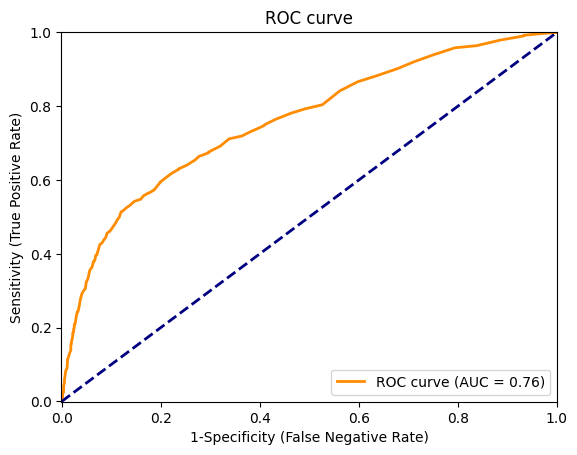

 AUC: 0.7580440712225135
Test Profit Value: 832500


In [56]:
# Use the trained model to predict testing data
y_pred_prob = classifier_RF.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > 0.4511084380182982, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Random Forest model: \n')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

#Calculating expected profit value
test_profit_value = calculate_objective_function(cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1])
print("Test Profit Value: " + str(test_profit_value))

Optimized hyper-parameters:{'n_estimators': 500}
Metrics of the Random Forest model with the optimized hyper-parameter for the "number of trees": 

Confusion matrix: 
[[1389  480]
 [ 189  342]]
                                   Accuracy: 0.72125
                   SENSITIVITY (aka RECALL): 0.6440677966101694
                 SPECIFICITY (aka FALL-OUT): 0.7431781701444623
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.41605839416058393
                 NEGATIVE PREDICTIVE VALUE): 0.8802281368821293


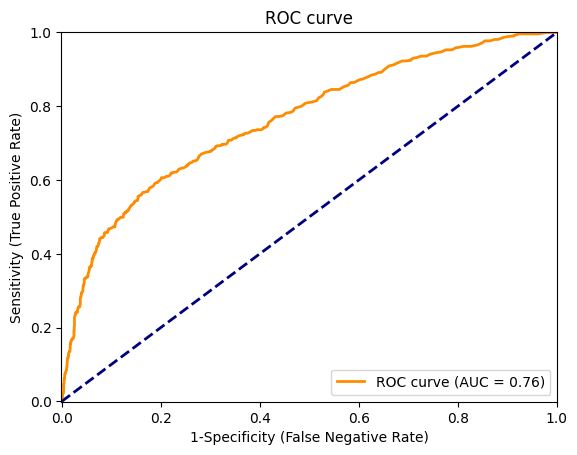

 AUC: 0.7627491462951375
Test Profit Value: 418500


In [32]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

n_trees = [100, 200, 300, 400, 500, 600] # as an example, we will tune the "numeber of trees" hyper-parameter (n_trees) and we will consider values of 100, 200, ... 600 trees in the forest
Grid_srch_parameters_list = [ [{'n_estimators':n_trees}] ]

# we will apply a 5-fold cross-validation and call the resultant function "grid_search"
grid_search = GridSearchCV(estimator = classifier_RF,
                           cv = 5,
                           param_grid = Grid_srch_parameters_list[0],
                           scoring = score_func,
                           return_train_score = True)

# apply function grid_search to the training data, call the resultand best model grid_search_RF
grid_search_RF = grid_search.fit(X_train, y_train)

# use the best model to predict the testing data
y_pred_prob = grid_search_RF.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > 0.4511084380182982, 1, 0) # classification

print('Optimized hyper-parameters:' + str(grid_search.best_params_))

# Lets look at the model metrics

print('Metrics of the Random Forest model with the optimized hyper-parameter for the "number of trees": \n')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

#Calculating expected profit value
test_profit_value = calculate_objective_function(cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1])
print("Test Profit Value: " + str(test_profit_value))

In [33]:
# Define the confusion matrix function
def compute_confusion_matrix(threshold, y_true, y_prob):
    y_pred = (y_prob > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    return cm

# Define the objective function to maximize
def objective_function(threshold, y_true, y_prob):
    cm = compute_confusion_matrix(threshold, y_true, y_prob)
    TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    return TN * 1500 - FN * 5000 - 1500 * FP + TP * 0

# Define a constraint that ensures the threshold is between 0 and 1
threshold_bounds = (0, 1)

# Use scipy's minimize_scalar to maximize the objective function
result = minimize_scalar(lambda threshold: -objective_function(threshold, y_test, y_pred_prob), bounds=threshold_bounds, method='bounded')

# Extract the optimized threshold value
optimized_threshold = result.x

# Use the optimized threshold to classify
y_pred_optimized = (y_pred_prob > optimized_threshold).astype(int)

# Print the optimized threshold and maximum objective function value
print("Optimized Threshold:", optimized_threshold)
print("Optimized Confusion Matrix:")
print(compute_confusion_matrix(optimized_threshold, y_test, y_pred_prob))
print("Maximized Objective Function Value:", objective_function(optimized_threshold, y_test, y_pred_prob))

Optimized Threshold: 0.4511084380182982
Optimized Confusion Matrix:
[[1723  146]
 [ 296  235]]
Maximized Objective Function Value: 885500


<Axes: title={'center': 'Feature Importance'}>

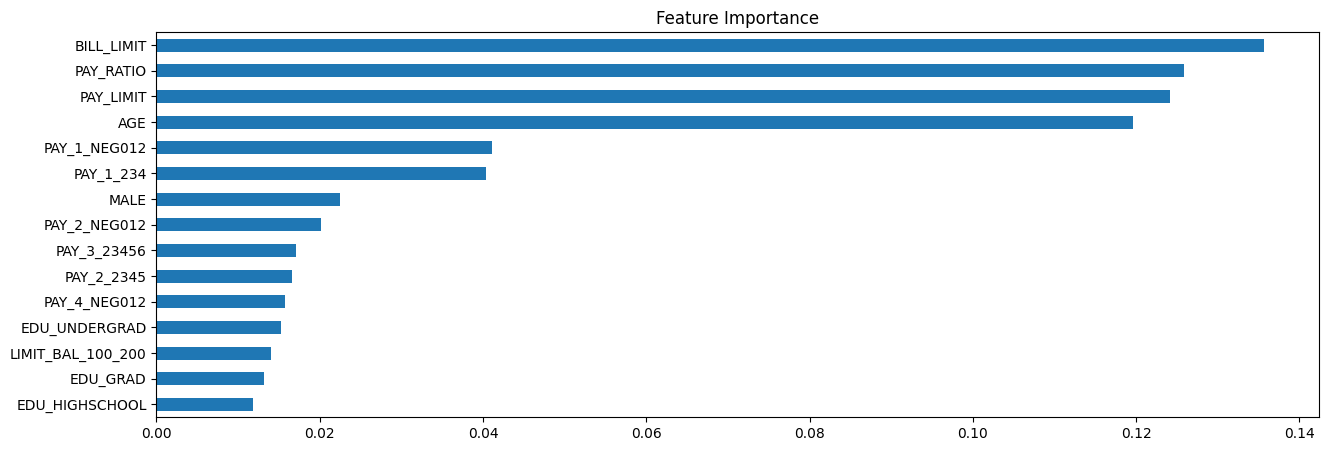

In [34]:
# Tree models do not have coefficients, but have easily-interpretable tree plots
# But in tree ensembles (such as random forect) there is no point to look at individual trees

# Useful intuition, however, can be obtained from the Feature Importance Plots

# calculate feature importances
importances = grid_search_RF.best_estimator_.feature_importances_

# plot them
plt.figure(figsize=(15,5))
plt.title('Feature Importance')
plt.xlabel('Decrease in Gini (recal, Gini = 2*AUC-1)')
feature_importances = pd.Series(classifier_RF.feature_importances_, index=X_train.columns)
feature_importances.nlargest(15).sort_values().plot(kind='barh', align='center')

## Summary for Random Forest:

- we first trained the model with default hyper-parameters
- applying it to testing set we got AUC=77.3%, with an expected profit value of 1,139,500, threshold = 0.23
- we then tuned the hyper-paramter "number of trees" and increased AUC to 77.5% with 600 trees, with an expected profit value of 1,213,500, threshold = 0.23
- we then optimized the threshold to 0.381 and got expected profit value of 1,800,500

# Method №4: Gradient Boosting Machine

In [43]:
# Define the gradient boosting machine model and call it classifier_GBM
classifier_GBM = GradientBoostingClassifier(random_state=77300)

# Train the model classifier_GBM on the training data
classifier_GBM.fit(X_train, y_train)

# A gradient boosting model has many hyper-parameters, for example::
# -- the number of trees in the forest ensemble,
# -- speed of boosting ("learning rate", "decay rate"),
# -- max number of leafs on each tree,
# -- min number of datapoints at a leaf
# and so on

GradientBoostingClassifier(random_state=77300)

Metrics of the Gradient Boosting Machine model: 

Confusion matrix: 
[[1724  145]
 [ 284  247]]
                                   Accuracy: 0.82125
                   SENSITIVITY (aka RECALL): 0.4651600753295669
                 SPECIFICITY (aka FALL-OUT): 0.922418405564473
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.6301020408163265
                 NEGATIVE PREDICTIVE VALUE): 0.8585657370517928


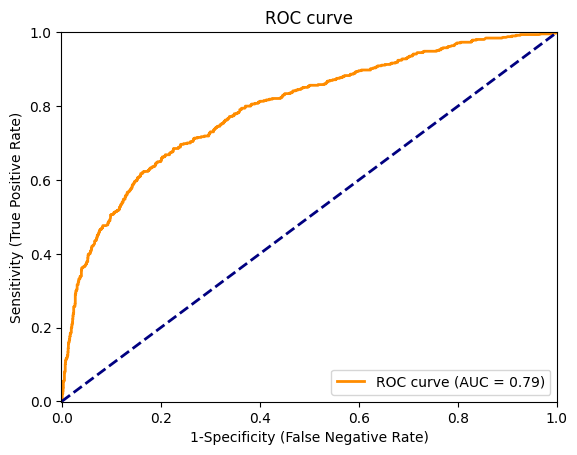

 AUC: 0.7942140524505787
Test Profit Value: 948500
GradientBoostingClassifier(random_state=77300)


In [86]:
# Use the trained model to predict testing data
y_pred_prob = classifier_GBM.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > 0.3739477540349918, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Gradient Boosting Machine model: \n')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

#Calculating expected profit value
test_profit_value = calculate_objective_function(cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1])
print("Test Profit Value: " + str(test_profit_value))

print(classifier_GBM)

In [45]:
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize_scalar

# Define the confusion matrix function
def compute_confusion_matrix(threshold, y_true, y_prob):
    y_pred = (y_prob > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    return cm

# Define the objective function to maximize
def objective_function(threshold, y_true, y_prob):
    cm = compute_confusion_matrix(threshold, y_true, y_prob)
    TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    return TN * 1500 - FN * 5000 - 1500 * FP + TP * 0

# Define a constraint that ensures the threshold is between 0 and 1
threshold_bounds = (0, 1)

# Use scipy's minimize_scalar to maximize the objective function
result = minimize_scalar(lambda threshold: -objective_function(threshold, y_test, y_pred_prob), bounds=threshold_bounds, method='bounded')

# Extract the optimized threshold value
optimized_threshold = result.x

# Use the optimized threshold to classify
y_pred_optimized = (y_pred_prob > optimized_threshold).astype(int)

# Print the optimized threshold and maximum objective function value
print("Optimized Threshold:", optimized_threshold)
print("Optimized Confusion Matrix:")
print(compute_confusion_matrix(optimized_threshold, y_test, y_pred_prob))
print("Maximized Objective Function Value:", objective_function(optimized_threshold, y_test, y_pred_prob))

Optimized Threshold: 0.3739477540349918
Optimized Confusion Matrix:
[[1724  145]
 [ 284  247]]
Maximized Objective Function Value: 948500


Optimized hyper-parameters:{'learning_rate': 0.1, 'n_estimators': 100}
Metrics of the Gradient Boosting Machine model with the optimized hyper-parameters": 

Confusion matrix: 
[[1576  208]
 [ 293  323]]
                                   Accuracy: 0.79125
                   SENSITIVITY (aka RECALL): 0.608286252354049
                 SPECIFICITY (aka FALL-OUT): 0.8432316746923488
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.5243506493506493
                 NEGATIVE PREDICTIVE VALUE): 0.8834080717488789


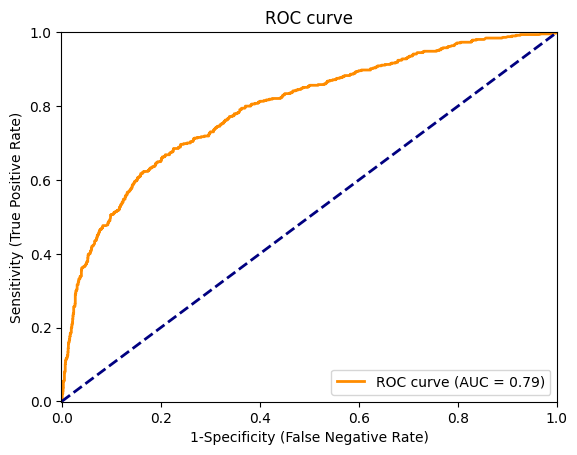

 AUC: 0.7942140524505787
Test Profit Value: 587000


In [41]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# as an example, we will tune two parameters
n_trees = [100,150, 200,250, 300, 450] # first, the "numeber of trees" hyper-parameter (n_trees) and we will consider values of 100, 200, ... 600 trees in the forest
learning_rates = [0.1, 0.15] # second, speed of boosting ("learning rate") and we will consider two values 0.01 и 0.1

Grid_srch_parameters_list = [ [{'n_estimators':n_trees, 'learning_rate': learning_rates}] ]

# we will apply a 5-fold cross-validation and call the resultant function "grid_search"
grid_search = GridSearchCV(estimator = classifier_GBM, cv = 5, param_grid = Grid_srch_parameters_list[0], scoring = score_func,
                              return_train_score = True)

# # apply function grid_search to the training data, call the resultant best model grid_search_GBM
grid_search_GBM = grid_search.fit(X_train, y_train)

# use the best model to predict the testing data
y_pred_prob = grid_search_GBM.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > 0.23, 1, 0) # classification

print('Optimized hyper-parameters:' + str(grid_search.best_params_))

# Lets look at the model metrics

print('Metrics of the Gradient Boosting Machine model with the optimized hyper-parameters": \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

#Calculating expected profit value
test_profit_value = calculate_objective_function(cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1])
print("Test Profit Value: " + str(test_profit_value))

In [42]:
# Define the confusion matrix function
def compute_confusion_matrix(threshold, y_true, y_prob):
    y_pred = (y_prob > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    return cm

# Define the objective function to maximize
def objective_function(threshold, y_true, y_prob):
    cm = compute_confusion_matrix(threshold, y_true, y_prob)
    TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    return TN * 1500 - FN * 5000 - 1500 * FP + TP * 0

# Define a constraint that ensures the threshold is between 0 and 1
threshold_bounds = (0, 1)

# Use scipy's minimize_scalar to maximize the objective function
result = minimize_scalar(lambda threshold: -objective_function(threshold, y_test, y_pred_prob), bounds=threshold_bounds, method='bounded')

# Extract the optimized threshold value
optimized_threshold = result.x

# Use the optimized threshold to classify
y_pred_optimized = (y_pred_prob > optimized_threshold).astype(int)

# Print the optimized threshold and maximum objective function value
print("Optimized Threshold:", optimized_threshold)
print("Optimized Confusion Matrix:")
print(compute_confusion_matrix(optimized_threshold, y_test, y_pred_prob))
print("Maximized Objective Function Value:", objective_function(optimized_threshold, y_test, y_pred_prob))

Optimized Threshold: 0.3739477540349918
Optimized Confusion Matrix:
[[1724  145]
 [ 284  247]]
Maximized Objective Function Value: 948500


## Summary for Gradient Boosting:

- we first trained the model with default hyper-parameters
- applying it to testing set we got AUC=78.7%
- we then tuned two hyper-paramters "number of trees" and "learning rate" , AUC decreased to 78.5%

# Method №5: Support Vector Machines

In [62]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_estimators = []
svm_estimators.append(('standardize', StandardScaler())) # scale the data
svm_estimators.append(('svm', svm.SVC(probability=True))) # define SVM with probabilities (recall, SVM be default does not predict probabilities)

# Define the support vectors machine model and call it classifier_SVM
Classifier_SVM = Pipeline(svm_estimators, verbose=False)

# Train the model classifier_SVM on the training data
Classifier_SVM.fit(X_train, y_train)

Pipeline(steps=[('standardize', StandardScaler()),
                ('svm', SVC(probability=True))])

Metrics of the Support Vector Machines model: 

Confusion matrix: 
[[1770   99]
 [ 322  209]]
                                   Accuracy: 0.8245833333333333
                   SENSITIVITY (aka RECALL): 0.3935969868173258
                 SPECIFICITY (aka FALL-OUT): 0.9470304975922953
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.6785714285714286
                 NEGATIVE PREDICTIVE VALUE): 0.8460803059273423


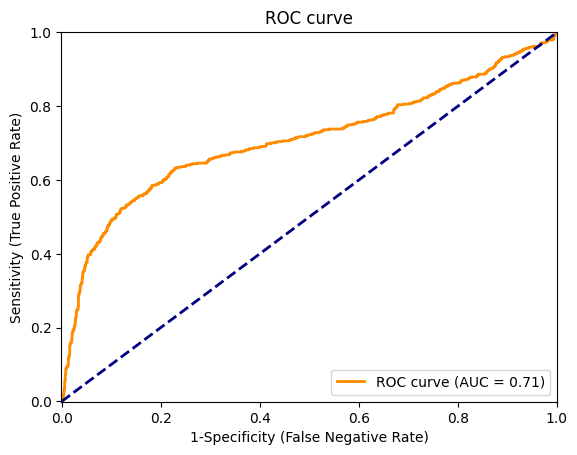

 AUC: 0.7084566406600306
Test Profit Value: 896500


In [40]:
# use the fitted model to predict the testing data
y_pred_prob = Classifier_SVM.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Support Vector Machines model: \n')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

#Calculating expected profit value
test_profit_value = calculate_objective_function(cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1])
print("Test Profit Value: " + str(test_profit_value))

In [41]:
# Define the confusion matrix function
def compute_confusion_matrix(threshold, y_true, y_prob):
    y_pred = (y_prob > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    return cm

# Define the objective function to maximize
def objective_function(threshold, y_true, y_prob):
    cm = compute_confusion_matrix(threshold, y_true, y_prob)
    TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    return TN * 1500 - FN * 5000 - 1500 * FP + TP * 0

# Define a constraint that ensures the threshold is between 0 and 1
threshold_bounds = (0, 1)

# Use scipy's minimize_scalar to maximize the objective function
result = minimize_scalar(lambda threshold: -objective_function(threshold, y_test, y_pred_prob), bounds=threshold_bounds, method='bounded')

# Extract the optimized threshold value
optimized_threshold = result.x

# Use the optimized threshold to classify
y_pred_optimized = (y_pred_prob > optimized_threshold).astype(int)

# Print the optimized threshold and maximum objective function value
print("Optimized Threshold:", optimized_threshold)
print("Optimized Confusion Matrix:")
print(compute_confusion_matrix(optimized_threshold, y_test, y_pred_prob))
print("Maximized Objective Function Value:", objective_function(optimized_threshold, y_test, y_pred_prob))

Optimized Threshold: 0.2360637310594416
Optimized Confusion Matrix:
[[1771   98]
 [ 323  208]]
Maximized Objective Function Value: 894500


In [ ]:
# Define the hyperparameter grid
param_grid = {
    'svm__C': [0.1, 1],  # Specify 'svm__C' for the SVM's C parameter
    'svm__gamma': [1, 0.1],
    'svm__kernel': ['rbf', 'poly', 'sigmoid']
}

# Create a GridSearchCV object and fit it to the training data
grid = GridSearchCV(Classifier_SVM, param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

# Use the best model to predict the testing data
y_pred_prob = grid.predict_proba(X_test)[:, 1]  # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0)  # classification

print('Optimized hyper-parameters:' + str(grid.best_params_))

# Let's look at the model metrics

print('Metrics of the SVM model with the optimized hyper-parameters: \n')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

#Calculating expected profit value
test_profit_value = calculate_objective_function(cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1])
print("Test Profit Value: " + str(test_profit_value))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..........svm__C=0.1, svm__gamma=1, svm__kernel=rbf; total time= 7.7min
[CV] END ..........svm__C=0.1, svm__gamma=1, svm__kernel=rbf; total time= 7.5min
[CV] END ..........svm__C=0.1, svm__gamma=1, svm__kernel=rbf; total time= 7.7min
[CV] END ..........svm__C=0.1, svm__gamma=1, svm__kernel=rbf; total time= 7.7min
[CV] END ..........svm__C=0.1, svm__gamma=1, svm__kernel=rbf; total time=22.2min


# Method №6: Artificial Neural Networks ("Deep Learning") with Tensor Flow

In [58]:
# conda install tensorflow keras

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [63]:
# Define the architecture and optimization metrics for the network
def create_model():
    model = keras.Sequential([
        layers.Dense(128,  activation="relu", name="hidden-dense-128-layer-1"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu", name="hidden-dense-64-layer-2"),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid', name="output-layer"),
    ])
    adam = tf.keras.optimizers.Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

nn_estimators = []
nn_estimators.append(('standardize', StandardScaler())) #scale the data
nn_estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=50, batch_size=128, validation_split=0.2))) # compile the model

# Define the TensorFlow Neural Network model and call it classifier_TF_NN
Classifier_TF_NN = Pipeline(nn_estimators, verbose=False)

# Train the model classifier_SVM on the training data
Classifier_TF_NN.fit(X_train, y_train)

Epoch 1/50
135/135 [==============================] - 2s 5ms/step - loss: 0.4753 - accuracy: 0.8023 - val_loss: 0.4393 - val_accuracy: 0.8185
Epoch 2/50
135/135 [==============================] - 0s 3ms/step - loss: 0.4500 - accuracy: 0.8141 - val_loss: 0.4346 - val_accuracy: 0.8204
Epoch 3/50
135/135 [==============================] - 0s 3ms/step - loss: 0.4434 - accuracy: 0.8183 - val_loss: 0.4349 - val_accuracy: 0.8204
Epoch 4/50
135/135 [==============================] - 0s 3ms/step - loss: 0.4393 - accuracy: 0.8186 - val_loss: 0.4354 - val_accuracy: 0.8199
Epoch 5/50
135/135 [==============================] - 0s 3ms/step - loss: 0.4354 - accuracy: 0.8211 - val_loss: 0.4334 - val_accuracy: 0.8201
Epoch 6/50
135/135 [==============================] - 0s 3ms/step - loss: 0.4335 - accuracy: 0.8196 - val_loss: 0.4364 - val_accuracy: 0.8194
Epoch 7/50
135/135 [==============================] - 0s 3ms/step - loss: 0.4340 - accuracy: 0.8206 - val_loss: 0.4365 - val_accuracy: 0.8213
Epoch 

Pipeline(steps=[('standardize', StandardScaler()),
                ('mlp',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F104958700>)])

75/75 [==============================] - 0s 1ms/step
Metrics of the Tensor Flow Neural Network model: 

Confusion matrix: 
[[1715  154]
 [ 288  243]]
                                   Accuracy: 0.8158333333333333
                   SENSITIVITY (aka RECALL): 0.4576271186440678
                 SPECIFICITY (aka FALL-OUT): 0.9176029962546817
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.6120906801007556
                 NEGATIVE PREDICTIVE VALUE): 0.8562156764852721


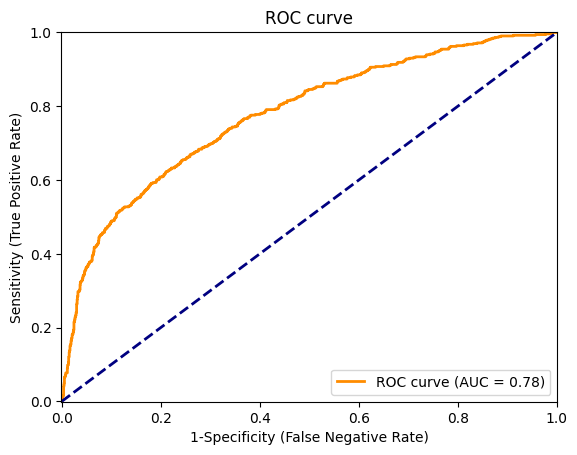

 AUC: 0.7763681193504085
Test Profit Value: 901500


In [68]:
# use the fitted model to predict the testing data
y_pred_prob = Classifier_TF_NN.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > 0.4245695285694349, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Tensor Flow Neural Network model: \n')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

#Calculating expected profit value
test_profit_value = calculate_objective_function(cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1])
print("Test Profit Value: " + str(test_profit_value))

In [66]:
# Define the confusion matrix function
def compute_confusion_matrix(threshold, y_true, y_prob):
    y_pred = (y_prob > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    return cm

# Define the objective function to maximize
def objective_function(threshold, y_true, y_prob):
    cm = compute_confusion_matrix(threshold, y_true, y_prob)
    TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    return TN * 1500 - FN * 5000 - 1500 * FP + TP * 0

# Define a constraint that ensures the threshold is between 0 and 1
threshold_bounds = (0, 1)

# Use scipy's minimize_scalar to maximize the objective function
result = minimize_scalar(lambda threshold: -objective_function(threshold, y_test, y_pred_prob), bounds=threshold_bounds, method='bounded')

# Extract the optimized threshold value
optimized_threshold = result.x

# Use the optimized threshold to classify
y_pred_optimized = (y_pred_prob > optimized_threshold).astype(int)

# Print the optimized threshold and maximum objective function value
print("Optimized Threshold:", optimized_threshold)
print("Optimized Confusion Matrix:")
print(compute_confusion_matrix(optimized_threshold, y_test, y_pred_prob))
print("Maximized Objective Function Value:", objective_function(optimized_threshold, y_test, y_pred_prob))

Optimized Threshold: 0.4245695285694349
Optimized Confusion Matrix:
[[1715  154]
 [ 288  243]]
Maximized Objective Function Value: 901500


## Summary for Tensor Flow NN:

- we trained the model with default hyper-parameters and some "semi-randomly"-selected architecture
- applying it to testing set we got AUC=82.7% -- one of the worst, across all methods
- but the low AUC thus far should not discounrage you: ANNs have an enormous number of tunable hyper-parameters, starting at the high-level with the network architecture. Lots to experiment with, and learn -- good luck!

In [58]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


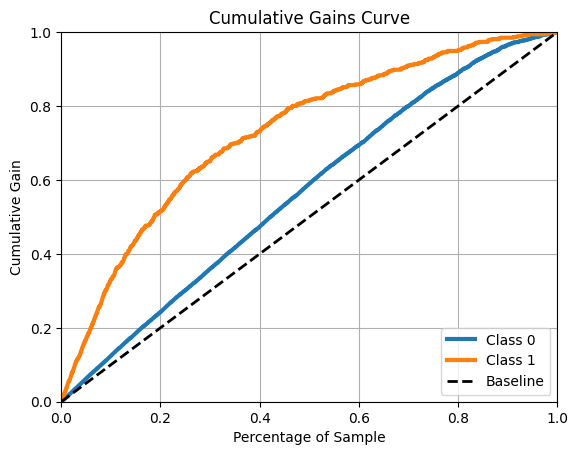

In [47]:
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_cumulative_gain

# Assuming you have trained your GBM regression model and made predictions
# Replace y_test and y_pred_prob with your actual target values and predicted probabilities

# Create the cumulative gains chart
plot_cumulative_gain(y_test, y_pred_proba)  # Use [:, 1] for the positive class probabilities

plt.title('Cumulative Gains Curve')
plt.xlabel('Percentage of Sample')
plt.ylabel('Cumulative Gain')
plt.show()

# Step 10: Finishing the analysis -- export the model predictions for subsequent use

In [68]:
#Loading and feature engineering Pilot data for prediction

#Import feature engineered dataset

import os
os.chdir('C:/Users/anton/MMA 867')

path = osp.join(osp.curdir,'Data','6722-pilot-customers-FE.csv')
df = pd.read_csv(path)

df.head() # show the "head" -- first 5 rows of the data; note, these are rows 0...4

,ID,LIMIT_BAL,LIMIT_BAL_10_30,LIMIT_BAL_30_60,LIMIT_BAL_60_100,LIMIT_BAL_100_200,LIMIT_BAL_200_300,LIMIT_BAL_300_400,LIMIT_BAL_400_500,LIMIT_BAL_500_750,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,BILL_LIMIT,PAY_LIMIT,PAY_RATIO
0,n1000-1,500000,0,0,0,0,0,0,0,1,...,473944,55000,40000,38000,20239,13750,13770,0.9082,0.0603,0.0663
1,n1000-2,210000,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.0000,0.0000,0.0000
2,n1000-3,150000,0,0,0,1,0,0,0,0,...,40788,4031,10006,3266,4040,1698,800,0.5327,0.0265,0.0497
3,n1000-4,20000,1,0,0,0,0,0,0,0,...,150,1699,1460,626,1750,150,0,0.7768,0.0474,0.0610
4,n1000-5,400000,0,0,0,0,0,0,1,0,...,7959,9677,11867,7839,14837,7959,5712,0.0299,0.0241,0.8060


In [69]:
# Define the bucket ranges and labels
bucket_ranges = [-np.inf, 0, 500000, 600000, np.inf]
bucket_labels = ['LT0', '0_500K', '500K_600K', 'GT600K']

# Columns for which to create dummy variables
bill_amt_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

# Loop through each BILL_AMT column and create dummy variables
for col in bill_amt_columns:
    df[f'BILL_AMT_{col[-1]}'] = pd.cut(df[col], bins=bucket_ranges, labels=bucket_labels, include_lowest=True)
    df = pd.concat([df, pd.get_dummies(df[f'BILL_AMT_{col[-1]}'], prefix=f'BILL_AMT_{col[-1]}')], axis=1)
    df.drop([f'BILL_AMT_{col[-1]}'], axis=1, inplace=True)

# Now, df contains dummy variables for all BILL_AMT columns

In [70]:
# Define bins and labels for PAY_AMT1 through PAY_AMT6
pay_amt_bins = [-np.inf, 0, 100000, 200000, 300000, 400000, 500000, 600000, np.inf]
pay_amt_labels = [
    'LT0', '0_100K', '100K_200K', '200K_300K', '300K_400K', '400K_500K', '500K_600K', 'GT600K'
]

# Loop through PAY_AMT1 to PAY_AMT6 columns and create dummy variables
for i in range(1, 7):
    col_name = f'PAY_AMT{i}'
    df[f'{col_name}_Bucket'] = pd.cut(df[col_name], bins=pay_amt_bins, labels=pay_amt_labels, include_lowest=True)

# Create dummy variables for PAY_AMT1 to PAY_AMT6 buckets
for i in range(1, 7):
    col_name = f'PAY_AMT{i}'
    df = pd.concat([df, pd.get_dummies(df[f'{col_name}_Bucket'], prefix=f'{col_name}')], axis=1)

# Drop the intermediate bucket columns
for i in range(1, 7):
    col_name = f'PAY_AMT{i}_Bucket'
    df.drop(columns=[col_name], inplace=True)

In [71]:
#Feature 4: # Calculate Aggregate statistics
bill_amount_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3','BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
payment_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3','PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
df['BILL_AMT_MEAN'] = df[bill_amount_cols].mean(axis=1)
df['PAY_AMT_MEAN'] = df[payment_cols].mean(axis=1)


#Feature 5
# Define the list of bill amount columns for months 1 to 3 and 4 to 6
bill_months_1_3 = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3']
bill_months_4_6 = ['BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

# Calculate the average percentage change for bill amounts (M1, M2, M3) vs (M4, M5, M6)
df['BILL_AMT_M1_M3_AVG'] = df[bill_months_1_3].mean(axis=1)
df['BILL_AMT_M4_M6_AVG'] = df[bill_months_4_6].mean(axis=1)
df['BILL_AMT_AVG_M1_M3_vs_M4_M6'] = (
    (df['BILL_AMT_M1_M3_AVG'] - df['BILL_AMT_M4_M6_AVG'])
    / df['BILL_AMT_M4_M6_AVG']  
).astype(float)


# Calculate the average percentage change for payment amounts (M1, M2, M3) vs (M4, M5, M6)
payment_months_1_3 = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3']
payment_months_4_6 = ['PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Calculate the average percentage change for payment amounts (M1, M2, M3) vs (M4, M5, M6)
# Calculate the average percentage change for payment amounts (M1, M2, M3) vs (M4, M5, M6)
df['PAY_AMT_M1_M3_AVG'] = df[payment_months_1_3].mean(axis=1)
df['PAY_AMT_M4_M6_AVG'] = df[payment_months_4_6].mean(axis=1)

# Calculate the average percentage change while handling division by zero
df['PAY_AMT_AVG_M1_M3_vs_M4_M6'] = (
    (df['PAY_AMT_M1_M3_AVG'] - df['PAY_AMT_M4_M6_AVG'])
    / df['PAY_AMT_M4_M6_AVG']  # Replace 0 with NaN to handle division by zero
).astype(float)

df = df.replace({True: 1, False: 0})

df.head()

df.replace([np.nan, np.inf, -np.inf], 0, inplace=True)

df.head()

,ID,LIMIT_BAL,LIMIT_BAL_10_30,LIMIT_BAL_30_60,LIMIT_BAL_60_100,LIMIT_BAL_100_200,LIMIT_BAL_200_300,LIMIT_BAL_300_400,LIMIT_BAL_400_500,LIMIT_BAL_500_750,...,PAY_AMT6_500K_600K,PAY_AMT6_GT600K,BILL_AMT_MEAN,PAY_AMT_MEAN,BILL_AMT_M1_M3_AVG,BILL_AMT_M4_M6_AVG,BILL_AMT_AVG_M1_M3_vs_M4_M6,PAY_AMT_M1_M3_AVG,PAY_AMT_M4_M6_AVG,PAY_AMT_AVG_M1_M3_vs_M4_M6
0,n1000-1,500000,0,0,0,0,0,0,0,1,...,0,0,454099.166667,30126.5,408331.666667,499866.666667,-0.183119,44333.333333,15919.666667,1.784815
1,n1000-2,210000,0,0,0,0,1,0,0,0,...,0,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,n1000-3,150000,0,0,0,1,0,0,0,0,...,0,0,79901.833333,3973.5,87041.000000,72762.666667,0.196232,5767.666667,2179.333333,1.646528
3,n1000-4,20000,1,0,0,0,0,0,0,0,...,0,0,15536.166667,947.5,18966.333333,12106.000000,0.566689,1261.666667,633.333333,0.992105
4,n1000-5,400000,0,0,0,0,0,0,1,0,...,0,0,11971.333333,9648.5,13731.000000,10211.666667,0.344638,9794.333333,9502.666667,0.030693


In [72]:
X_PILOT = df.drop(columns=['ID','LIMIT_BAL',
    'LIMIT_BAL_GT750',
    'SEX',
    'EDUCATION',
    'MARITALSTATUS_OTHER',
    'AGE_L21',
'AGE_21_25',
'AGE_25_30',
'AGE_30_35',
'AGE_35_40',
'AGE_40_45',
'AGE_45_50',
'AGE_50_55',
'AGE_55_60',
'AGE_60_65',
'AGE_65_70',
'AGE_70_75',
'AGE_75_80',
'AGE_GT80',
    'AGE_GT80',
    'PAY_1',
    'PAY_2',
    'PAY_3',
    'PAY_4',
    'PAY_5',
    'PAY_6',
    'BILL_AMT1',
    'BILL_AMT2',
    'BILL_AMT3',
    'BILL_AMT4',
    'BILL_AMT5',
    'BILL_AMT6',
    'PAY_AMT1_GT600K',
    'PAY_AMT2_GT600K',
    'PAY_AMT3_GT600K',
    'PAY_AMT4_GT600K',
    'PAY_AMT5_GT600K',
    'PAY_AMT6_GT600K',
    'BILL_AMT_MEAN',
    'PAY_AMT_MEAN',
    'BILL_AMT_M1_M3_AVG',
    'BILL_AMT_M4_M6_AVG',
    'BILL_AMT_AVG_M1_M3_vs_M4_M6',
    'PAY_AMT_M1_M3_AVG',
    'PAY_AMT_M4_M6_AVG',
    'PAY_AMT_AVG_M1_M3_vs_M4_M6',
    'PAY_AMT1',
    'PAY_AMT2' ,                   
    'PAY_AMT3',
    'PAY_AMT4',
    'PAY_AMT5',      
    'PAY_AMT6',
'Repayment_Status_1',
'Repayment_Status_234',
'Repayment_Status_GT4',
'Repayment_Status_NEG2',
'Repayment_Status_NEG1',
'Repayment_Status_0'])

In [53]:
# Make predictions with the logistic regression model on the pilot dataset
y_pred_prob = classifier_GBM.predict_proba(X_PILOT)[:, 1]

# Create a DataFrame with the predictions and probabilities
result_df = pd.DataFrame({'DEFAULT_Prob': y_pred_prob})

# Add the 'DEFAULT' column based on the specified threshold
result_df['DEFAULT'] = np.where(result_df['DEFAULT_Prob'] > 0.3739477540349918, 1, 0)

# Add the 'ISSUE_CREDIT' column based on the 'DEFAULT' column
result_df['ISSUE_CREDIT'] = np.where(result_df['DEFAULT'] == 0, 1, 0)

# Add back the 'ID' column to the result DataFrame
result_df['ID'] = df['ID']

# Concatenate X_PILOT with the result_df to include the existing columns
result_df = pd.concat([X_PILOT, result_df], axis=1)

In [54]:
# Export result_df as an Excel file
result_df.to_excel('6722-pilot-customers-PRED.xlsx', index=False)